# ARR Analysis

## Goal

ARR prediction, where ARR=RoomIncome_Main/room_nights

## Roadmap

1. Load dataset
- Features Engineering (+Cleaning)
- Exploratory Data Analysis (EDA)
    - High level statistics
    - Features Histograms
    - Data Encoding (categorigal+numeric)
    - Correlation Matrix
- Basic Modelling
    - Linear Regression
    - Ridge (L2)
    - Lasso (L1)
    - Elastic-Net (L1+L2)
    - Support Vector Regression (SVR)
- Trees
    - Decision Trees
    - Random Forest (ensemble)
    - XGBoost (boosted)
- Neural Networks
    - Multi-layer Perceptron
    - LSTM RNN (Tensorflow)
    - LSTM AutoEncoder (Tensorflow)
- Statistical Forcasting
    - SARIMAX
    - FBProphet
 
<br><br>
<div><img src="https://miro.medium.com/max/1400/1*OmxKKDqcVm_UCOYT9i5TJw.png" width=750"/></div>

<hr>

# Initialization

Import required libraries

In [1]:
import glob
import json
import shap
import xlrd
import pylab
import codecs
import joblib
import datetime
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from os import path, environ
from fbprophet import Prophet
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.inspection import plot_partial_dependence, permutation_importance
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, GridSearchCV
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
sns.set(color_codes=True)

pylab.rcParams['figure.figsize'] = (60.0, 20.0)
pylab.rcParams['font.size'] = 14
pylab.rcParams['figure.max_open_warning'] = 0

sns.set(); sns.reset_defaults

%matplotlib inline

print("tensorflow version: %s" % str(tf.__version__))
print("xgboost version: %s" % str(xgb.__version__))

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


tensorflow version: 2.3.0
xgboost version: 1.0.0


User Parameters:

In [2]:
dataset_path = "../Data/Ramblas/Ramblas.txt"
events_path = "../Data/Ramblas/eventsBarcelona.xlsx"
avail_path = "../Data/Ramblas/RamblaAvail/*.txt"
additional_path = "../Data/Ramblas/AddistionalSpainData.xlsx"
plangrp_path = None

save_path = 'saved_data/'
scaling_mode = "standard"
hyper_params_en = False
overwrite_saved_data = False

index_var = 'res_date'
dependent_var ='ARR'

m_lead_days_max = 300
room_nights_min = 0
room_nights_max = 7
RoomIncome_Main_min = 0
RoomIncome_Main_max = 4000
dependent_var_max = 400
cv_ratio = 0.2
singles_only = False
fulfilled_only = False

models = ['linear_regressor',       # 0
          'ridge_regressor',        # 1
          'lasso_regressor',        # 2
          'elasticnet_regressor',   # 3
          'supportvect_regressor',  # 4 
          'decisiontree_regressor', # 5
          'randomforest_regressor', # 6
          'xgboost_regressor',      # 7
          'mlp_regressor',          # 8
          'lstm_rnn',               # 9
          'lstm_autoencoder',       # 10
          'sarima',                 # 11
          'fbprophet']              # 12

External parameters:

In [3]:
if not 'hotel_sel' in locals():
    hotel_sel = 468.0 

Load reservations dataset

In [4]:
reservations_data = pd.read_csv(dataset_path, sep='\t', lineterminator='\r')
reservations_data[index_var]=pd.to_datetime(reservations_data[index_var].astype(str), format='%Y-%m-%d')
reservations_data = reservations_data[reservations_data[index_var] < '2020-03-01']

In [5]:
display(reservations_data.head())

,res_date,hotel,master,res,wing,group_member,nationality,m_length_of_stay,bed_nights,room_nights,...,Cxl_Reason_code,CXL_LeadDays,adults,juniors,children,babies,club_code,StatisticSource,Commission_Main,Commission_Second
0,2018-12-15,468,42595,1,1.0,0,fra,1,2,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-18,468,42647,1,1.0,0,gbr,3,2,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-19,468,42647,1,1.0,0,gbr,3,2,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-17,468,42647,1,1.0,0,gbr,3,2,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-02-10,468,42851,1,1.0,0,otr,20,1,1.0,...,NaN,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
hotels = reservations_data['hotel'].unique()
hotels = np.sort(hotels[~np.isnan(hotels)])
print('Hotels:\n%s\n' % str(hotels))
print('Selected: %s\n' % str(hotel_sel))

Hotels:
[468]

Selected: 468.0



Load special events

events_df (123, 9)


,FairId,FairName,FromDate,ToDate,Scope,Hotel/ Region Code,Hotel/ Region Name,Fair Category,HotelId
0,26,Barcelona Meeting,2015-10-21,2015-10-24,City,Barcelona,Barcelona,A,0
1,37,Gastech,2018-09-17,2018-09-20,City,Barcelona,Barcelona,B,0
2,62,CPHI - Barcelona,2016-10-04,2016-10-06,City,Barcelona,Barcelona,A,0
3,133,Estudia,2016-03-09,2016-03-13,City,Barcelona,Barcelona,C,0
4,133,Estudia,2017-03-22,2017-03-26,City,Barcelona,Barcelona,C,0


<AxesSubplot:>

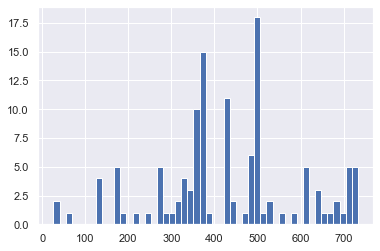

In [7]:
events_df = pd.read_excel(events_path)

print('events_df', events_df.shape)
display(events_df.head())
events_df["FairId"].hist(bins=50)

additional_df (1186, 8)


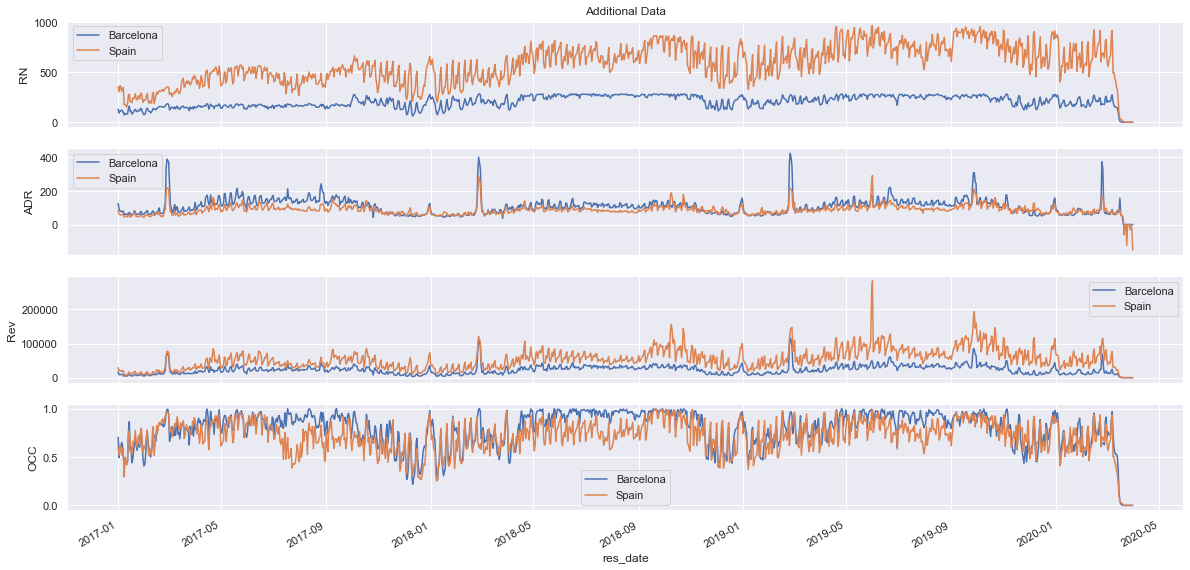

In [8]:
sheet_names = list(pd.read_excel(additional_path, None).keys())

df1 = pd.read_excel(additional_path, sheet_name=sheet_names[0])
df2 = pd.read_excel(additional_path, sheet_name=sheet_names[1])

additional_df = df1.merge(df2,
                          left_on='Res_Date', 
                          right_on='Res_Date',
                          suffixes=('_' + sheet_names[0], '_' + sheet_names[1]))
                         
additional_df = additional_df.set_index('Res_Date')
additional_df = additional_df.replace('(null)',np.nan).fillna(0)

print('additional_df', additional_df.shape)

x = additional_df.index.unique()
fig, ax = plt.subplots(4,1,figsize=(20,10), sharex=True)
for k, txt in enumerate(['RN', 'ADR', 'Rev', 'OCC']):
    ax[k].plot(x, additional_df[txt+'_Barcelona'], additional_df[txt+'_Spain'])
    ax[k].set_ylabel(txt)
    ax[k].legend(['Barcelona', 'Spain'])
ax[0].set_title('Additional Data')
ax[3].set_xlabel(index_var)
ax[3].xaxis_date()
fig.autofmt_xdate()
plt.show()

In [9]:
additional_df.head()

,RN_Barcelona,ADR_Barcelona,Rev_Barcelona,OCC_Barcelona,RN_Spain,ADR_Spain,Rev_Spain,OCC_Spain
Res_Date,,,,,,,,
2017-01-01,131.0,125.4,16424.0,0.7043,355,82.5,29273.0,0.5976
2017-01-02,92.0,93.1,8565.0,0.4946,305,63.1,19256.0,0.5135
2017-01-03,114.0,80.6,9189.0,0.6129,365,58.4,21318.0,0.6145
2017-01-04,112.0,80.3,8997.0,0.6022,360,57.4,20650.0,0.6061
2017-01-05,121.0,75.3,9110.0,0.6505,310,57.7,17888.0,0.5219


Load Availability

availability_df (1461, 4)


,date_taken,AvailRooms,hotel_rooms,capacity
178784,2016-01-02,117.0,117.0,1.0
178785,2016-01-03,117.0,117.0,1.0
171640,2016-01-04,117.0,117.0,1.0
171641,2016-01-05,117.0,117.0,1.0
169657,2016-01-06,117.0,117.0,1.0


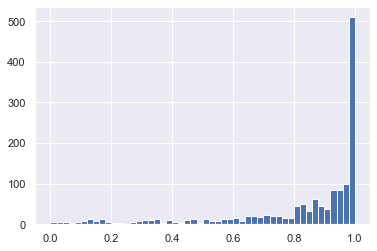

In [10]:
if avail_path:
    
    all_files = glob.glob(avail_path)

    li = []
    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0, low_memory=False, sep=',', encoding='utf-16')
        li.append(df)

    availability_df = pd.concat(li, axis=0, ignore_index=True)

    availability_df['date_taken'] = availability_df['date_taken'].astype('datetime64')

    availability_df['capacity'] = availability_df['AvailRooms'] / availability_df['hotel_rooms']
    availability_df['capacity'] = availability_df['capacity'].clip(lower=0)

    availability_df = availability_df[availability_df['hotel'] == hotel_sel].drop('hotel', axis=1)
    availability_df = availability_df.drop('res_date', axis=1).sort_values('date_taken')
    availability_df = availability_df.drop_duplicates(subset='date_taken', keep='last')

    print('availability_df', availability_df.shape)
    display(availability_df.head())
    availability_df['capacity'].hist(bins=50)

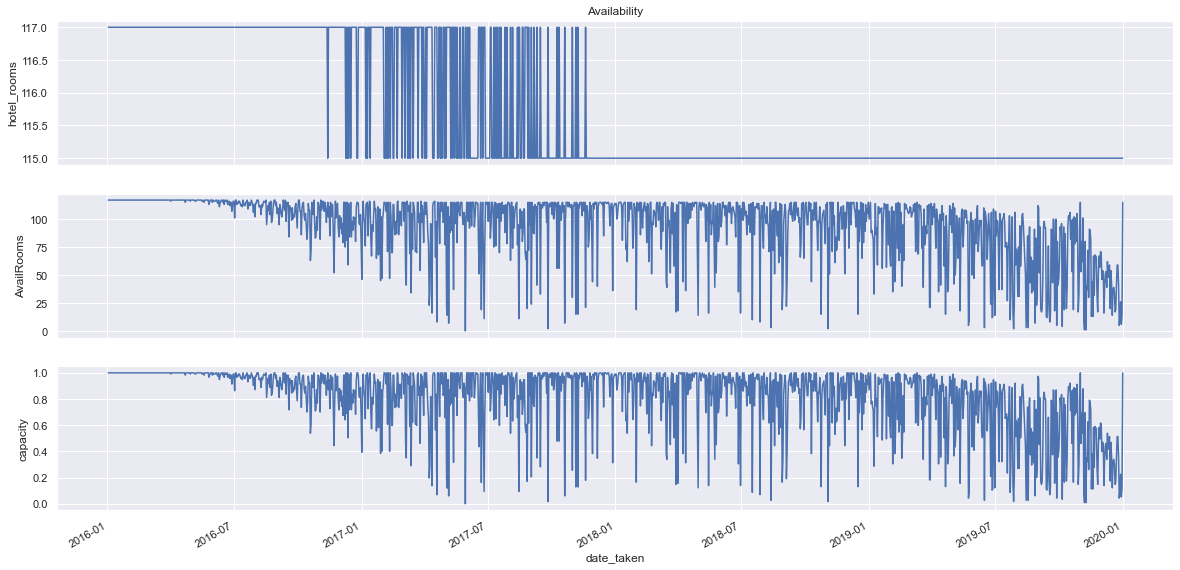

In [11]:
x = availability_df.date_taken.unique()
fig, ax = plt.subplots(3,1,figsize=(20,10), sharex=True)
ax[0].plot(x, availability_df['hotel_rooms'])
ax[1].plot(x, availability_df['AvailRooms'])
ax[2].plot(x, availability_df['capacity'])
ax[0].set_ylabel('hotel_rooms')
ax[1].set_ylabel('AvailRooms')
ax[2].set_ylabel('capacity')
ax[0].set_title('Availability')
ax[2].set_xlabel('date_taken')
fig.autofmt_xdate()
ax[2].xaxis_date()
plt.show()

Load Plan Grouping

In [12]:
if plangrp_path:

    plan_grouping_df = pd.read_excel(plangrp_path)
    plan_grouping_df.columns = [*plan_grouping_df.columns[:-1], 'plan_code']

    print('plan_grouping_df', plan_grouping_df.shape)
    display(plan_grouping_df.head())

<hr>

# Features Engineering (+Cleaning)

Focus on relevant attributes + Cleaning

In [13]:
reservations_data2 = reservations_data.copy()

# Focus on a specific hotel:
reservations_data2 = reservations_data2[reservations_data2['hotel'] == hotel_sel]

reservations_data2['date_taken'] = pd.to_datetime(reservations_data2['Date_taken'], errors='coerce')
reservations_data2['date_taken'] = reservations_data2['date_taken'].dt.date.astype(str)

# Clean (filter):
reservations_data2 = reservations_data2[(reservations_data2['m_lead_days']<m_lead_days_max) &
                                        (reservations_data2['room_nights']>room_nights_min) & 
                                        (reservations_data2['room_nights']<room_nights_max) &
                                        (reservations_data2['RoomIncome_Main']>RoomIncome_Main_min) &
                                        (reservations_data2['RoomIncome_Main']<RoomIncome_Main_max)]
reservations_data2['date_taken'] = reservations_data2['date_taken'].astype('datetime64[ns]')

# Keep only Singles reservations:
if singles_only:
    singles_ids = [1, 4, 6, 11, 15, 21, 30, 31, 34]
    reservations_data2 = reservations_data2[reservations_data2['market_segment_bi_id'].isin(singles_ids)]

# Keep only fulfilled reservations:
if fulfilled_only:
    fulfilled_ids = ['arriv', 'chkin', 'chkou', 'res']
    reservations_data2 = reservations_data2[reservations_data2['reservation_status'].isin(fulfilled_ids)]

# Extract relevant features only:
reservations_data2 = reservations_data2[['res_date',
                                         'RoomTypes_desc',
                                         'market_segment_bi_id',
                                         'MainCust',
                                         'source',
                                         'sales_channel',
                                         'club_code',
                                         'StatisticSource',
                                         'package_code',
                                         'nationality',
                                         'group_member',
                                         'm_length_of_stay',
                                         'bed_nights',
                                         'm_lead_days',
                                         'adults',
                                         'juniors',
                                         'children',
                                         'babies',
                                         'plan_desc',                                         
                                         'RoomIncome_Main',
                                         'room_nights',
                                         'date_taken']]


index_var_dt = pd.to_datetime(reservations_data2[index_var], errors='coerce')
s = index_var_dt.values[:,None]

# Add 'event_id' sideband feature (for specific hotel):
s1 = events_df['HotelId'].values
s2 = events_df['FromDate'].values
s3 = events_df['ToDate'].values
reservations_data2['event_id'] = (np.dot(((s1==hotel_sel)|(s1==0))&(s>=s2)&(s<=s3), events_df.FairId))
reservations_data2['event_id'] = reservations_data2['event_id'].astype(str)

# Add 'day_of_week' feature:
reservations_data2['day_of_week'] = index_var_dt.dt.day_name()

# Add Availability feature (for specific hotel)
reservations_data2 = pd.merge(reservations_data2, 
                              availability_df[['date_taken','capacity']], 
                              on='date_taken',
                              how='left')
reservations_data2['capacity'] = reservations_data2['capacity'].fillna(1.0)
reservations_data2 = reservations_data2.drop(['date_taken'], axis=1)

# Add Plan Code feature:
if plangrp_path:
    reservations_data2 = pd.merge(reservations_data2, 
                                  plan_grouping_df[['plan_desc','plan_code']], 
                                  on='plan_desc', 
                                  how='left')
    reservations_data2 = reservations_data2.drop(['plan_desc'], axis=1)

# Add Additional-Data features
reservations_data2 = pd.merge(reservations_data2, 
                              additional_df.reset_index().rename(columns={'Res_Date':'res_date'}), 
                              on='res_date',
                              how='left')

# Mark categorigal features:
reservations_data2['market_segment_bi_id'] = reservations_data2['market_segment_bi_id'].astype(str)

# Dependent variable:
reservations_data2[dependent_var] = (reservations_data2['RoomIncome_Main'] / reservations_data2['room_nights']).fillna(0)
reservations_data2 = reservations_data2.drop(['RoomIncome_Main'], axis=1)

# MA features:
#reservations_data2['ma2'] = reservations_data2[dependent_var].groupby(reservations_data2.index).mean().rolling(window=2).mean()
#reservations_data2['ma3'] = reservations_data2[dependent_var].groupby(reservations_data2.index).mean().rolling(window=3).mean()
reservations_data2['ma7'] = reservations_data2[dependent_var].groupby(reservations_data2.index).mean().rolling(window=7).mean()
reservations_data2['ma14'] = reservations_data2[dependent_var].groupby(reservations_data2.index).mean().rolling(window=14).mean()
#reservations_data2['ma21'] = reservations_data2[dependent_var].groupby(reservations_data2.index).mean().rolling(window=21).mean()
#reservations_data2['ma28'] = reservations_data2[dependent_var].groupby(reservations_data2.index).mean().rolling(window=28).mean()
reservations_data2['ma100'] = reservations_data2[dependent_var].groupby(reservations_data2.index).mean().rolling(window=100).mean()

# Additional cleanup (dependent variable related):
reservations_data2 = reservations_data2[(reservations_data2[dependent_var] < dependent_var_max)]

Reservation dataframe finalization:

In [14]:
# Reservations dataframe finalization
reservations_df = reservations_data2.copy()
reservations_df[index_var] = pd.to_datetime(reservations_df[index_var])
reservations_df = reservations_df.set_index(index_var)
reservations_df = reservations_df.sort_index()
reservations_df = reservations_df.drop_duplicates()

# Add a synthetic time (unique)
reservations_df = reservations_df.set_index(pd.to_datetime(reservations_df.index) + 
                                            pd.to_timedelta(reservations_df.groupby(level=0).cumcount(), unit='s'))

Data Cleaning (fillna, per column)

In [15]:
for col in reservations_df:
    dt = reservations_df[col].dtype 
    if dt == int or dt == float:
        reservations_df[col] = reservations_df[col].fillna(0)
    else:
        reservations_df[col] = reservations_df[col].fillna("")

Debug mixed types cases

In [16]:
%%script false --no-raise-error

df = pd.DataFrame(reservations_df['nationality'])
weird = (df.applymap(type) != df.iloc[0].apply(type)).any(axis=1)
display(df[weird])

<hr>

# Data Exploration ("mini-EDA")

### Quick look:

In [17]:
print('reservations_df shape: %s' % str(reservations_df.shape))
display(reservations_df.head())

reservations_df shape: (103430, 34)


,RoomTypes_desc,market_segment_bi_id,MainCust,source,sales_channel,club_code,StatisticSource,package_code,nationality,group_member,...,Rev_Barcelona,OCC_Barcelona,RN_Spain,ADR_Spain,Rev_Spain,OCC_Spain,ARR,ma7,ma14,ma100
2017-01-01 00:00:00,Budget Room,21,1,int,expedia,0.0,0.0,0.0,ita,0,...,16424.0,0.7043,355,82.5,29273.0,0.5976,77.73,125.731429,129.330000,113.8611
2017-01-01 00:00:01,Budget Room,21,1,int,expedia,0.0,0.0,0.0,otr,0,...,16424.0,0.7043,355,82.5,29273.0,0.5976,105.00,137.851429,133.314286,113.9505
2017-01-01 00:00:02,deluxe/ executive room,21,1,int,expedia,0.0,0.0,0.0,bel,0,...,16424.0,0.7043,355,82.5,29273.0,0.5976,229.10,153.511429,177.452857,117.7313
2017-01-01 00:00:03,Budget Room,21,1,int,expedia,0.0,0.0,0.0,fra,0,...,16424.0,0.7043,355,82.5,29273.0,0.5976,80.84,117.847143,127.408571,113.6699
2017-01-01 00:00:04,Budget Room,21,1,int,expedia,0.0,0.0,0.0,swe,0,...,16424.0,0.7043,355,82.5,29273.0,0.5976,73.75,109.451429,124.876429,113.9206


In [18]:
reservations_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 103430 entries, 2017-01-01 00:00:00 to 2020-02-29 00:01:48
Data columns (total 34 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   RoomTypes_desc        103430 non-null  object 
 1   market_segment_bi_id  103430 non-null  object 
 2   MainCust              103430 non-null  int64  
 3   source                103430 non-null  object 
 4   sales_channel         103430 non-null  object 
 5   club_code             103430 non-null  float64
 6   StatisticSource       103430 non-null  float64
 7   package_code          103430 non-null  float64
 8   nationality           103430 non-null  object 
 9   group_member          103430 non-null  int64  
 10  m_length_of_stay      103430 non-null  int64  
 11  bed_nights            103430 non-null  int64  
 12  m_lead_days           103430 non-null  int64  
 13  adults                103430 non-null  float64
 14  juniors           

Dependent variable overview:

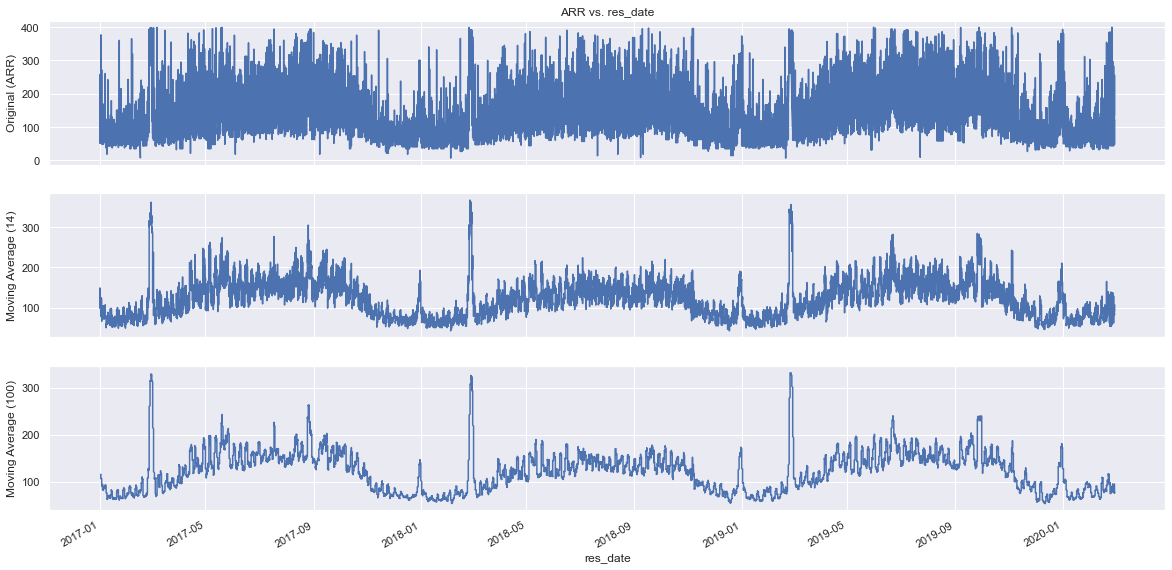

In [19]:
x = reservations_df.index.unique()
y1 = reservations_df[dependent_var].groupby(reservations_df.index).mean()
y2 = reservations_df[dependent_var].groupby(reservations_df.index).mean().rolling(window=14).mean()
y3 = reservations_df[dependent_var].groupby(reservations_df.index).mean().rolling(window=100).mean()

fig, ax = plt.subplots(3,1,figsize=(20,10), sharex=True)
ax[0].plot(x, y1)
ax[1].plot(x, y2)
ax[2].plot(x, y3)
ax[2].xaxis_date()
fig.autofmt_xdate()
ax[2].set_xlabel(index_var)
ax[0].set_ylabel('Original (%s)' % dependent_var)
ax[1].set_ylabel('Moving Average (14)')
ax[2].set_ylabel('Moving Average (100)')
ax[0].set_title('%s vs. %s' % (dependent_var,index_var))
plt.show()

### Encode the dataset

In [20]:
encoded_pre_df = reservations_df.drop([dependent_var], axis=1)

# Label Encoding:
enc_lbl = LabelEncoder()
encoded_categorical_df = encoded_pre_df.select_dtypes(include=['object']).apply(enc_lbl.fit_transform)

# OneHot Encoding:
enc_oh = OneHotEncoder(handle_unknown='ignore')
encoded_categorical_oh_df = pd.DataFrame(enc_oh.fit_transform(encoded_categorical_df).toarray(), 
                                         index=reservations_df.index)
encoded_categorical_oh_df.columns = enc_oh.get_feature_names(encoded_categorical_df.columns)

# Numerical Features:
encoded_numerical_df = encoded_pre_df.select_dtypes(exclude=['object'])

# Merge back into a single dataframe:
encoded_df = pd.concat([encoded_categorical_oh_df, encoded_numerical_df], axis=1, sort=False)
    
print('Features (after encoding):\n')
print(encoded_df.shape)
display(encoded_df.head())
display(encoded_df.describe())

Features (after encoding):

(103430, 294)


,RoomTypes_desc_0,RoomTypes_desc_1,RoomTypes_desc_2,RoomTypes_desc_3,RoomTypes_desc_4,RoomTypes_desc_5,market_segment_bi_id_0,market_segment_bi_id_1,market_segment_bi_id_2,market_segment_bi_id_3,...,ADR_Barcelona,Rev_Barcelona,OCC_Barcelona,RN_Spain,ADR_Spain,Rev_Spain,OCC_Spain,ma7,ma14,ma100
2017-01-01 00:00:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,125.4,16424.0,0.7043,355,82.5,29273.0,0.5976,125.731429,129.330000,113.8611
2017-01-01 00:00:01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,125.4,16424.0,0.7043,355,82.5,29273.0,0.5976,137.851429,133.314286,113.9505
2017-01-01 00:00:02,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,125.4,16424.0,0.7043,355,82.5,29273.0,0.5976,153.511429,177.452857,117.7313
2017-01-01 00:00:03,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,125.4,16424.0,0.7043,355,82.5,29273.0,0.5976,117.847143,127.408571,113.6699
2017-01-01 00:00:04,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,125.4,16424.0,0.7043,355,82.5,29273.0,0.5976,109.451429,124.876429,113.9206


,RoomTypes_desc_0,RoomTypes_desc_1,RoomTypes_desc_2,RoomTypes_desc_3,RoomTypes_desc_4,RoomTypes_desc_5,market_segment_bi_id_0,market_segment_bi_id_1,market_segment_bi_id_2,market_segment_bi_id_3,...,ADR_Barcelona,Rev_Barcelona,OCC_Barcelona,RN_Spain,ADR_Spain,Rev_Spain,OCC_Spain,ma7,ma14,ma100
count,103430.000000,103430.000000,103430.000000,103430.000000,103430.000000,103430.000000,103430.000000,103430.000000,103430.000000,103430.000000,...,103430.000000,103430.000000,103430.000000,103430.000000,103430.000000,103430.000000,103430.000000,103430.000000,103430.000000,103430.000000
mean,0.343604,0.377221,0.030223,0.114077,0.000164,0.134709,0.016688,0.000039,0.020990,0.010635,...,112.239904,24824.935802,0.833345,607.773741,91.192541,57762.767717,0.747942,129.601748,129.995033,130.622268
std,0.474913,0.484693,0.171202,0.317906,0.012819,0.341415,0.128099,0.006219,0.143352,0.102578,...,43.892409,12204.763706,0.144084,180.394505,26.965859,28994.348654,0.140352,47.153504,43.703877,35.040044
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,36.400000,3039.000000,0.218300,154.000000,42.100000,7671.000000,0.250900,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,80.400000,15653.000000,0.757000,473.000000,75.500000,37890.000000,0.657100,97.482857,101.225893,110.610100
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,111.600000,24469.000000,0.873200,608.000000,87.600000,54306.000000,0.767300,125.267857,126.616786,128.428950
75%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,132.600000,31897.000000,0.950700,755.000000,102.800000,72496.000000,0.856700,154.422857,153.123214,148.066150
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,424.900000,115996.000000,1.000000,968.000000,292.600000,283281.000000,0.990900,1100.830000,731.610714,416.473200


### Histogram Analysis

Dependent variable histogram

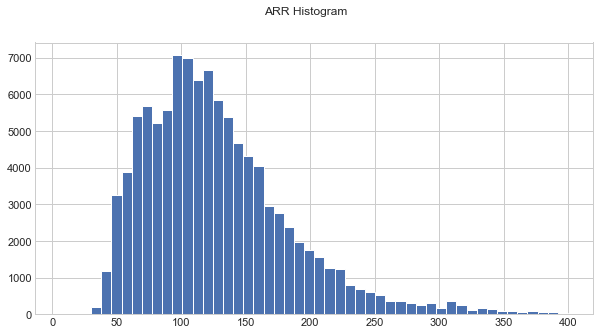

ARR min, mean, max = 6.53, 127.40, 399.98
ARR uniques (7753):
 [  6.53   6.58   7.28 ... 399.35 399.58 399.98]


In [21]:
plt.style.use('seaborn-whitegrid')
reservations_data2[dependent_var].hist(bins=50, figsize=(10,5))
plt.suptitle('%s Histogram' % dependent_var)
plt.show()

s = reservations_data2[dependent_var]
s_unique = np.sort(s.unique())
print('%s min, mean, max = %.2f, %.2f, %.2f' % (dependent_var,min(s),np.mean(s),max(s)))
print('%s uniques (%d):\n %s' % (dependent_var, len(s_unique), str(s_unique)))

Features Histograms

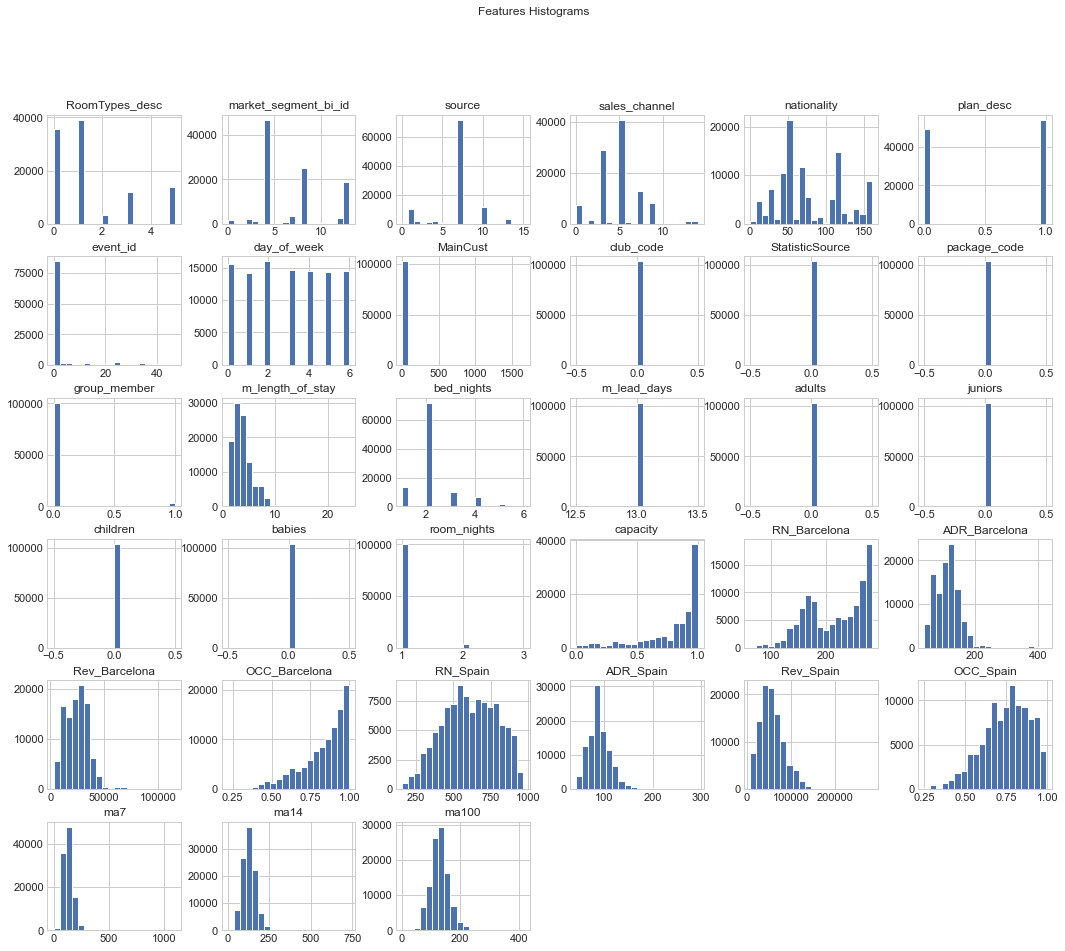

In [22]:
plt.style.use('seaborn-whitegrid')
encoded_hist_df = pd.concat([encoded_categorical_df, encoded_numerical_df], axis=1, sort=False)
encoded_hist_df.hist(bins=20, figsize=(18,15))
plt.suptitle('Features Histograms')
plt.show()

### Correlation Matrix

A correlation matrix is a table showing correlation coefficients between variables. Each cell in the table shows the correlation between two variables.<br>
The __Pearson__ and __Spearman__ correlation coefficients can range in value from −1 to +1 ([link](https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/supporting-topics/basics/a-comparison-of-the-pearson-and-spearman-correlation-methods/)).<br>
The __Pearson__ correlation evaluates the __linear__ relationship between two continuous variables.<br>
The __Spearman__ correlation evaluates the __monotonic__ relationship between two continuous or ordinal variables.

In [23]:
dependent_series = reservations_df[dependent_var]
encoded_df2 = pd.concat([encoded_df, dependent_series], axis=1)

Relevant Features (Pearson):

event_id_0                 0.204200
RoomTypes_desc_5           0.210208
market_segment_bi_id_6     0.215170
event_id_6                 0.226897
market_segment_bi_id_13    0.227531
bed_nights                 0.251298
RN_Spain                   0.255311
RN_Barcelona               0.272576
RoomTypes_desc_0           0.282118
RoomTypes_desc_3           0.290640
OCC_Spain                  0.341440
Rev_Spain                  0.432021
ma100                      0.460729
OCC_Barcelona              0.499087
ADR_Spain                  0.560040
ma14                       0.590676
Rev_Barcelona              0.634579
ma7                        0.659929
ADR_Barcelona              0.675351
ARR                        1.000000
Name: ARR, dtype: float64 

Relevant Features (Spearman):

RoomTypes_desc_5           0.211398
market_segment_bi_id_13    0.234439
bed_nights                 0.249214
RoomTypes_desc_3           0.261991
RoomTypes_desc_0           0.299119
RN_Spain   

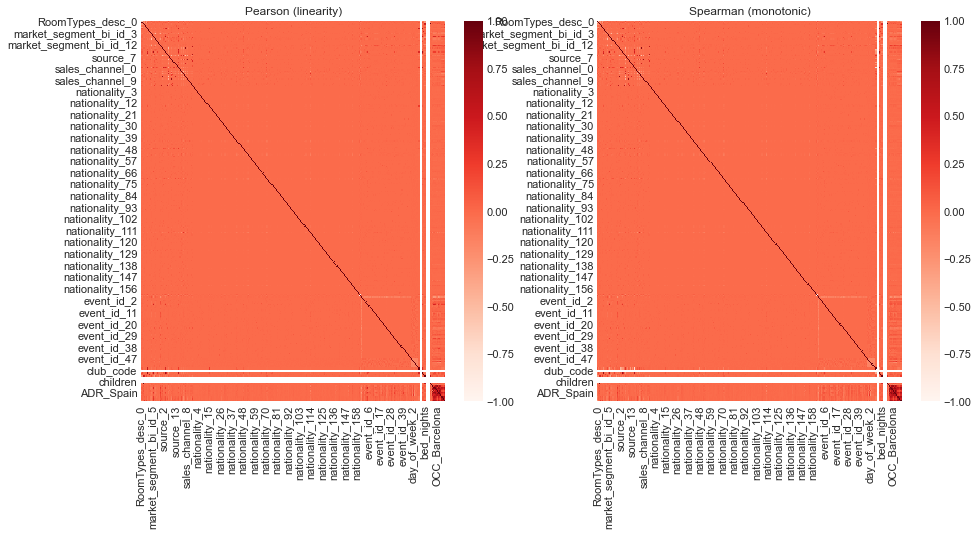

In [24]:
pearson_cor = encoded_df2.corr(method='pearson')
spearman_cor = encoded_df2.corr(method='spearman')

# Highlight relevant features
pearson_cor_targets = abs(pearson_cor[dependent_var])
spearman_cor_targets = abs(spearman_cor[dependent_var])
print('Relevant Features (Pearson):\n')
print(pearson_cor_targets[pearson_cor_targets > 0.2].sort_values(), '\n')
print('Relevant Features (Spearman):\n')
print(spearman_cor_targets[spearman_cor_targets > 0.2].sort_values())

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
sns.heatmap(pearson_cor, ax=ax1, annot=False, cmap=plt.cm.Reds)
sns.heatmap(spearman_cor, ax=ax2, annot=False, cmap=plt.cm.Reds)
ax1.set_title('Pearson (linearity)')
ax2.set_title('Spearman (monotonic)')
plt.show()

In [25]:
%%script false --no-raise-error

plt.figure(figsize=(12,10))
ax = plt.axes()
sns.heatmap(pearson_cor, annot=True, cmap=plt.cm.Reds, ax=ax)
ax.set_title('Pearson (monotonic)')
plt.show()

plt.figure(figsize=(12,10))
ax = plt.axes()
sns.heatmap(spearman_cor, annot=True, cmap=plt.cm.Reds, ax=ax)
ax.set_title('Spearman (monotonic)')
plt.show()

<hr>

# Auxiliary Methods

In [26]:
def get_cv_scores(model, X_train, y_train):
    scores = cross_val_score(model,
                             X_train,
                             y_train,
                             cv=5,
                             scoring='r2')

    print('CV Mean Accuracy: ', np.mean(scores))
    print('CV STD Accuracy: ', np.std(scores), '\n')

In [27]:
def plot_model_results(model, X_train, X_test, y_train, y_test, y_pred):

    y_pred_train = model.predict(X_train)

    y_trn_smp = pd.DataFrame(y_train, index=X_train.index)
    y_trn_prd = pd.DataFrame(y_pred_train, index=X_train.index)
    y_tst_smp = pd.DataFrame(y_test, index=X_test.index)
    y_tst_prd = pd.DataFrame(y_pred, index=X_test.index)

    y_trn_smp_ma = y_trn_smp.groupby(y_trn_smp.index).mean().rolling(window=14).mean().fillna(0)
    y_trn_prd_ma = y_trn_prd.groupby(y_trn_prd.index).mean().rolling(window=14).mean().fillna(0)
    y_tst_smp_ma = y_tst_smp.groupby(y_tst_smp.index).mean().rolling(window=14).mean().fillna(0)
    y_tst_prd_ma = y_tst_prd.groupby(y_tst_prd.index).mean().rolling(window=14).mean().fillna(0)
    
    y_trn_ma = pd.concat([y_trn_smp_ma, y_trn_prd_ma], axis=1)
    y_trn_ma.columns = ['Sampled', 'Predicted']
    
    y_tst_ma = pd.concat([y_tst_smp_ma, y_tst_prd_ma], axis=1)
    y_tst_ma.columns = ['Sampled', 'Predicted']    
    
    # Figure 1:
    plt.figure(figsize=(20,12))
    
    plt.subplot(221)
    plt.scatter(y_train, y_pred_train)
    plt.plot(y_train, y_train, color='red', linewidth=1, linestyle='dashed')    
    plt.title('Train-Set')
    plt.xlabel('Sampled')
    plt.ylabel("Predicted")

    plt.subplot(222)
    plt.scatter(y_test, y_pred)
    plt.plot(y_test, y_test, color='red', linewidth=1, linestyle='dashed')    
    plt.title('Test-Set')
    plt.xlabel('Sampled')
    plt.ylabel("Predicted")

    plt.show()
    
    # Figure 2:
    fig, ax = plt.subplots(1, 2, figsize=(20,6))
    y_trn_ma.plot(ax=ax[0], linewidth=1)
    ax[0].xaxis_date()
    ax[0].set_title('Train-Set - Sampled vs. Predicted (MA=14)')
    ax[0].set_xlabel('Time')
    ax[0].legend()

    y_tst_ma.plot(ax=ax[1], linewidth=1)
    ax[1].xaxis_date()
    ax[1].set_title('Test-Set - Sampled vs. Predicted (MA=14)')
    ax[1].set_xlabel('Time')
    ax[1].legend()

    fig.autofmt_xdate()

    plt.show()

In [28]:
def plot_tree_features_importance(feature_importances, feature_labels, threshold):
    feature_import_val = feature_importances[feature_importances > threshold]
    feature_import_lbl = feature_labels[feature_importances > threshold]

    plt.figure(figsize=(12,6))
    plt.bar(feature_import_lbl, feature_import_val)
    plt.xticks(rotation='vertical')
    plt.title('Features Importance')
    plt.show()

In [29]:
def plot_permutation_importance(model, X, y, topN, n_repeats=10, random_state=42):
    result = permutation_importance(model, X, y, n_repeats=10, random_state=42)
    perm_sorted_idx = result.importances_mean.argsort()

    feature_import_val = result.importances[perm_sorted_idx].T[:,-topN:]
    feature_import_lbl = X.columns[perm_sorted_idx][-topN:]

    plt.figure(figsize=(12,6))
    plt.boxplot(feature_import_val, vert=False, labels=feature_import_lbl)
    plt.xticks(rotation='vertical')
    plt.title('Permutation Importance')
    plt.show()

In [30]:
def plot_partial_dependencies(model, X, target_features):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title("Partial Dependencies")
    plot_partial_dependence(model, X, target_features, ax=ax, line_kw={"c": "red"})

In [31]:
def plot_partial_2d_dependencies(model, X, target_feature1, target_feature2):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title("Partial Dependencies, 2D")
    plot_partial_dependence(model, 
                            X,
                            [(list(X.columns).index(target_feature1),
                              list(X.columns).index(target_feature2))],
                            n_jobs=3,
                            grid_resolution=20,
                            ax=ax)

In [32]:
def plot_learning_curve(history):

    fig, axes = plt.subplots(1, 1, figsize=(20,10))
    axes.plot(history['loss'], 'b', label='Train', linewidth=2)
    axes.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
    axes.set_title('Learning Curve', fontsize=20)
    axes.set_ylabel('Loss (mae)', fontsize=15)
    axes.set_xlabel('Epoch', fontsize=15)
    axes.legend(loc='upper right')
    plt.show()

In [33]:
def print_model_accuracy(model, X_train, y_train, X_test, y_test):
    score_trn = model.score(X_train, y_train) if abs(model.score(X_train, y_train))<=1 else 0
    score_tst = model.score(X_test, y_test) if abs(model.score(X_test, y_test))<=1 else 0
    print('Train Accuracy: ', score_trn)
    print('Test Accuracy: ', score_tst)

<hr>

# Basic Modelling

Linear Modelling:

![](https://miro.medium.com/max/1400/1*0W935wbGEcLZoqXIxkuhTQ.png)

### Normalization

In [34]:
scaler = MinMaxScaler if scaling_mode == "minmax" else StandardScaler()
encoded_scl_df = pd.DataFrame(scaler.fit_transform(encoded_df), 
                              index=encoded_df.index,
                              columns=encoded_df.columns)

encoded_scl_df.describe()

,RoomTypes_desc_0,RoomTypes_desc_1,RoomTypes_desc_2,RoomTypes_desc_3,RoomTypes_desc_4,RoomTypes_desc_5,market_segment_bi_id_0,market_segment_bi_id_1,market_segment_bi_id_2,market_segment_bi_id_3,...,ADR_Barcelona,Rev_Barcelona,OCC_Barcelona,RN_Spain,ADR_Spain,Rev_Spain,OCC_Spain,ma7,ma14,ma100
count,1.034300e+05,1.034300e+05,1.034300e+05,1.034300e+05,1.034300e+05,1.034300e+05,1.034300e+05,1.034300e+05,1.034300e+05,103430.000000,...,1.034300e+05,1.034300e+05,1.034300e+05,1.034300e+05,1.034300e+05,1.034300e+05,1.034300e+05,1.034300e+05,1.034300e+05,1.034300e+05
mean,-2.747917e-18,-5.166085e-17,-1.868584e-17,-1.099167e-18,-3.434897e-18,5.935502e-17,2.638001e-17,3.434897e-18,-1.456396e-17,0.000000,...,3.297501e-16,1.143134e-16,1.626767e-16,-4.396668e-17,2.088417e-16,5.495835e-18,8.793336e-18,-5.276001e-17,3.869068e-16,-2.638001e-16
std,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005,...,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00
min,-7.235133e-01,-7.782717e-01,-1.765368e-01,-3.588404e-01,-1.282144e-02,-3.945646e-01,-1.302721e-01,-6.218922e-03,-1.464243e-01,-0.103680,...,-1.727868e+00,-1.785044e+00,-4.268672e+00,-2.515464e+00,-1.820553e+00,-1.727647e+00,-3.541425e+00,-2.748521e+00,-2.974465e+00,-3.727818e+00
25%,-7.235133e-01,-7.782717e-01,-1.765368e-01,-3.588404e-01,-1.282144e-02,-3.945646e-01,-1.302721e-01,-6.218922e-03,-1.464243e-01,-0.103680,...,-7.254115e-01,-7.515082e-01,-5.298659e-01,-7.471092e-01,-5.819439e-01,-6.854047e-01,-6.472502e-01,-6.811593e-01,-6.582775e-01,-5.711256e-01
50%,-7.235133e-01,-7.782717e-01,-1.765368e-01,-3.588404e-01,-1.282144e-02,-3.945646e-01,-1.302721e-01,-6.218922e-03,-1.464243e-01,-0.103680,...,-1.457900e-02,-2.916382e-02,2.766114e-01,1.254253e-03,-1.332262e-01,-1.192227e-01,1.379248e-01,-9.191071e-02,-7.729894e-02,-6.259491e-02
75%,1.382145e+00,1.284898e+00,-1.765368e-01,-3.588404e-01,-1.282144e-02,-3.945646e-01,-1.302721e-01,-6.218922e-03,-1.464243e-01,-0.103680,...,4.638660e-01,5.794539e-01,8.144943e-01,8.161389e-01,4.304523e-01,5.081440e-01,7.748997e-01,5.263920e-01,5.292046e-01,4.978295e-01
max,1.382145e+00,1.284898e+00,5.664540e+00,2.786754e+00,7.799434e+01,2.534439e+00,7.676241e+00,1.607996e+02,6.829468e+00,9.645065,...,7.123364e+00,7.470157e+00,1.156657e+00,1.996890e+00,7.469016e+00,7.778044e+00,1.731075e+00,2.059726e+01,1.376579e+01,8.157875e+00


### Cross Validation (Train/Test split)

R-squared (R²), Mean Squared Error (MSE), Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) are the most commonly used metrics to measure accuracy for continuous variables.<br>
The focus here is on R-Squared, aka the coefficient of determination, which implies how much variance in the target variable can be explained by the model.<br>
Values can range from 0 to 1. Higher values indicate a model that is highly predictive.<br>
For example, a R² value of 0.80 means that the model is accounting for 80% of the variability in the data.<br>
In general, the higher the R² value the better. However, a very high R² could be a sign of overfitting. <br>
Low values indicate that our model is not very good at predicting the target.<br>

<div><img src="https://miro.medium.com/max/2000/1*RZ7wWxTZxb6ySGGWJaY-CQ.jpeg" width=800"/></div>

Split the data into training and testing with a ratio of 80% and 20%

In [35]:
X_train, X_test, y_train, y_test = train_test_split(encoded_scl_df, 
                                                    dependent_series, 
                                                    test_size=cv_ratio, 
                                                    random_state=27,
                                                    shuffle=False)   # essential for TimeSeries

X_train = X_train.sort_index()
X_test = X_test.sort_index()
y_train = y_train.sort_index()
y_test = y_test.sort_index()

X_train.index = X_train.index.rename(index_var)
X_test.index = X_test.index.rename(index_var)
y_train.index = y_train.index.rename(index_var)
y_test.index = y_test.index.rename(index_var)

Prepare a combined Xy version as well

In [36]:
scaler_xy_train = MinMaxScaler if scaling_mode == "minmax" else StandardScaler()
scaler_xy_test = MinMaxScaler if scaling_mode == "minmax" else StandardScaler()

Xy_train = X_train.copy()
Xy_train[dependent_var] = y_train.values
Xy_train = pd.DataFrame(scaler_xy_train.fit_transform(Xy_train),
                        index=Xy_train.index,
                        columns=Xy_train.columns)

Xy_test = X_test.copy()
Xy_test[dependent_var] = y_test.values
Xy_test = pd.DataFrame(scaler_xy_test.fit_transform(Xy_test),
                       index=Xy_test.index,
                       columns=Xy_test.columns)

<hr>

### Linear Regressor

Linear regression finds the parameters to minimize the mean squared error or residuals between the predictions and the targets.<br>

<div><img src="https://gohantimes.com/wp-content/uploads/2019/11/ols-sum-of-square-diff.png" width="500"/></div>

Model: linear_regressor
Train Accuracy:  0.7471535662831083
Test Accuracy:  0


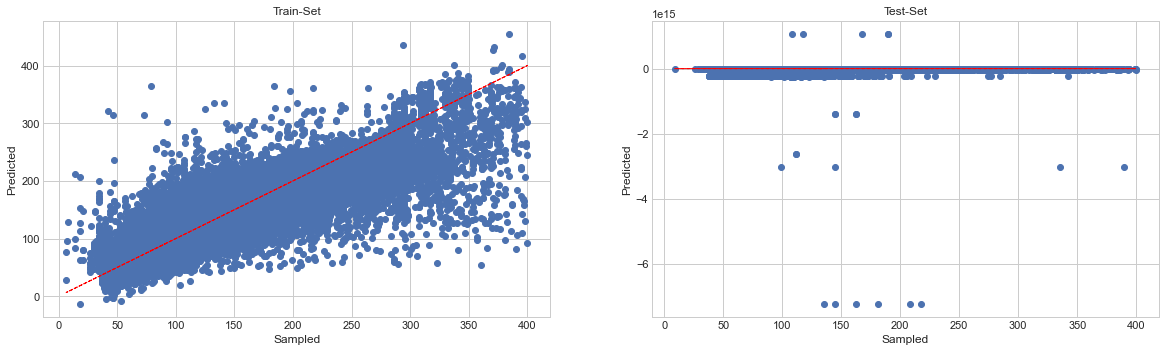

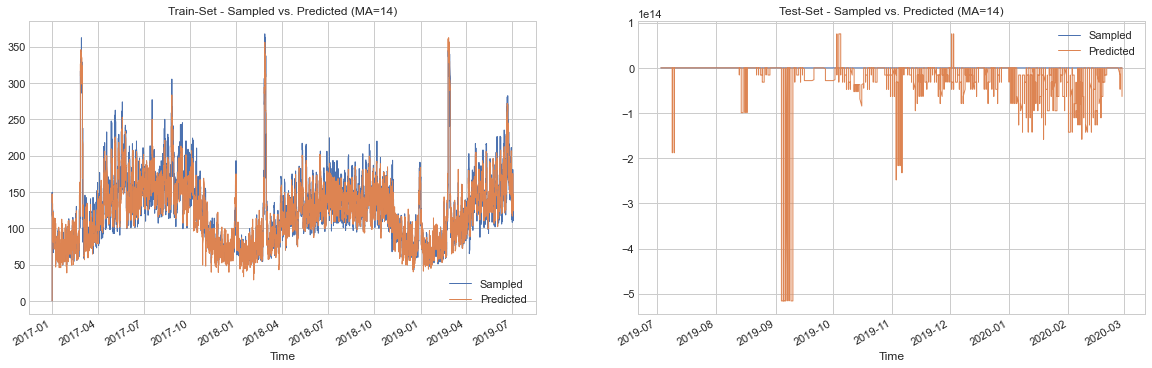

In [37]:
model_name = models[0]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)

else:
    
    # Create object
    model = LinearRegression(n_jobs=4)

    # Train the model using the training sets
    model = model.fit(X_train, y_train)

    # Save the model
    joblib.dump(model, model_file) 

    # Get cross validation scores
    get_cv_scores(model, X_train, y_train)

print_model_accuracy(model, X_train, y_train, X_test, y_test)
    
# Make predictions using the testing set
y_pred = model.predict(X_test)

# Plot
plot_model_results(model, X_train, X_test, y_train, y_test, y_pred)

Examine the coefficients:

In [38]:
for coef, col in enumerate(X_train.columns[:10]):
    print('%s --> %.2f' % (col, model.coef_[coef]))

RoomTypes_desc_0 --> -30446988362091.70
RoomTypes_desc_1 --> -31073998643939.21
RoomTypes_desc_2 --> -10975877461471.31
RoomTypes_desc_3 --> -20381185903550.96
RoomTypes_desc_4 --> -821859663412.59
RoomTypes_desc_5 --> -21888308144499.92
market_segment_bi_id_0 --> 1505236829653.27
market_segment_bi_id_1 --> 73073562934.29
market_segment_bi_id_2 --> 1684465622405.70
market_segment_bi_id_3 --> -21514846838339.12


<hr>

### Ridge Regressor

Ridge regression uses L2 regularization to minimize the magnitude of the coefficients.<br>
It reduces the size of the coefficients and helps reduce model complexity.<br>
We control the complexity of our model with the regularization parameter, ⍺.<br>
Higher values of ⍺ force coefficients to move towards zero and increases the restriction on the model.<br>
This decreases training performance, but also increases the generalizability of the model. 

Model: ridge_regressor
Train Accuracy:  0.7538615279374034
Test Accuracy:  0.610742561391783


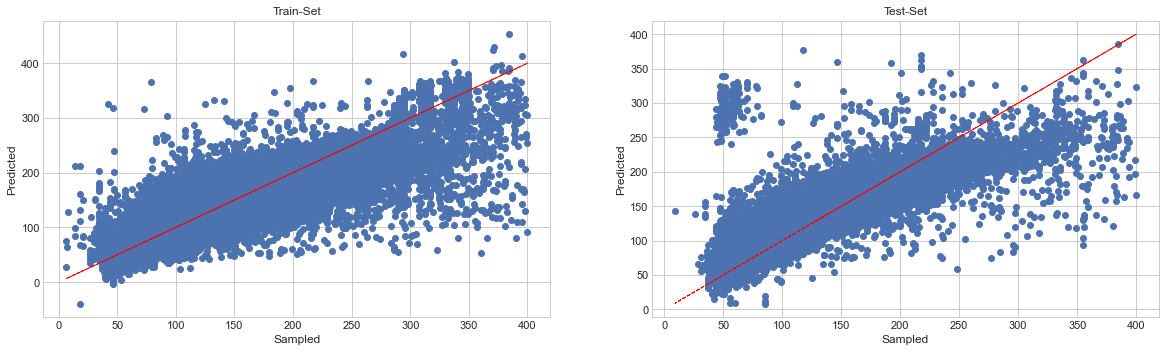

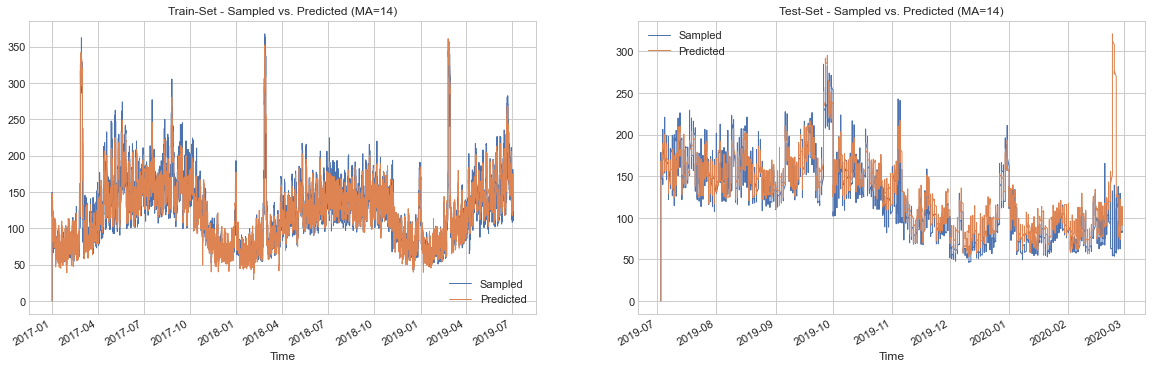

In [39]:
model_name = models[1]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)

else:
    
    # Create object
    model = Ridge(alpha=0.1)

    # Hyper-Parameters optimization:
    if hyper_params_en:

        model = GridSearchCV(model,
                             {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
                             scoring='r2', 
                             verbose=1,
                             n_jobs=1).estimator

    # Train the model using the training sets
    model.fit(X_train, y_train)

    # Save the model
    joblib.dump(model, model_file)    
    
    # Get cross validation scores
    get_cv_scores(model, X_train, y_train)

print_model_accuracy(model, X_train, y_train, X_test, y_test)
    
# Make predictions using the testing set
y_pred = model.predict(X_test)

# Plot
plot_model_results(model, X_train, X_test, y_train, y_test, y_pred)

#### Plot Partial Dependencies (PDP)
Partial dependence plots (PDP) show the dependence between the target response and a set of ‘target’ features, marginalizing over the values of all other features (the ‘complement’ features). Intuitively, we can interpret the partial dependence as the expected target response as a function of the ‘target’ features.<br> X-axis represents the 'target feature', while y-axis represents the model prediction.<br>
[reference](https://www.kaggle.com/dansbecker/partial-dependence-plots)

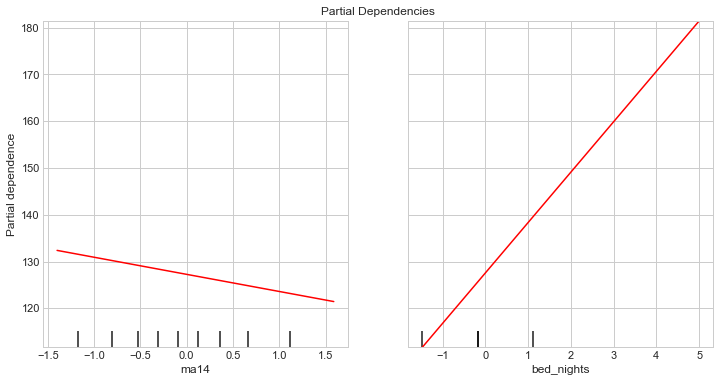

In [40]:
plot_partial_dependencies(model, X_train, ["ma14", "bed_nights"])

We can clearly see a linear relationship among these featrues.<br>
Note that PDPs assume that the target features are independent from the complement features, and this assumption is often violated in practice.

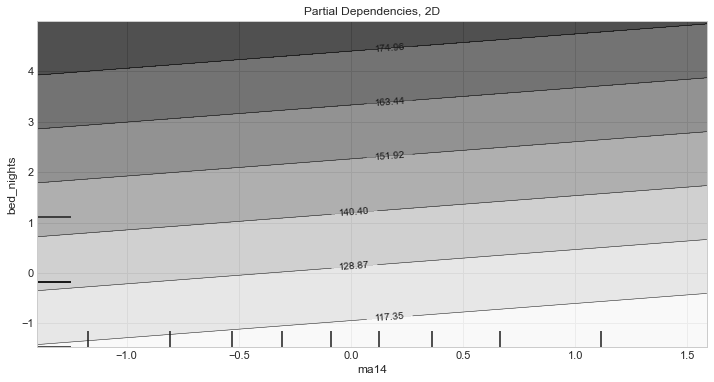

In [41]:
plot_partial_2d_dependencies(model, X_train, "ma14", "bed_nights")

#### Permutation Importance
“Permutation importance” is model-agnostic variable importance approach, so they do not require a single variable-related discrete training process like decision tree. The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled.<br>
[reference](https://scikit-learn.org/stable/modules/permutation_importance.html)

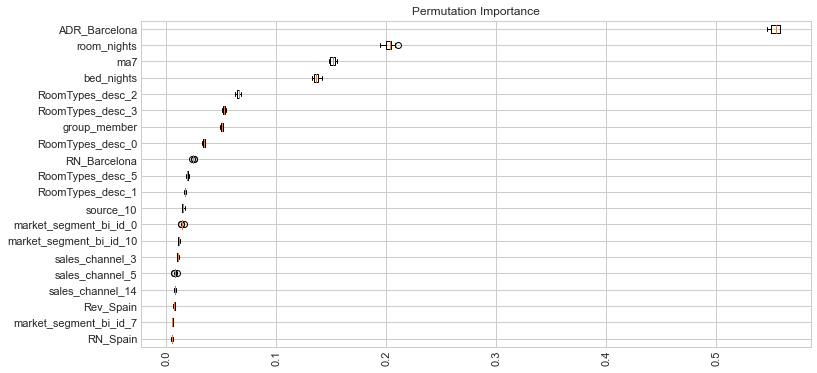

In [42]:
plot_permutation_importance(model, X_test, y_test, 20)

<hr>

### Lasso Regressor

Lasso regression uses L1 regularization to force some coefficients to be exactly zero.<br>
This means some features are completely ignored by the model. <br>
This can be thought of as a type of automatic feature selection!<br>
Lasso can be a good model choice when we have a large number of features but expect only a few to be important.<br>
Higher values of ⍺ force more coefficients to zero and can cause underfitting.<br>
Lower values of alpha lead to fewer non-zero features and can cause overfitting.<br>
Very low values of alpha will cause the model to resemble linear regression.

Model: lasso_regressor
Train Accuracy:  0.7525372740020487
Test Accuracy:  0.6147896351643137


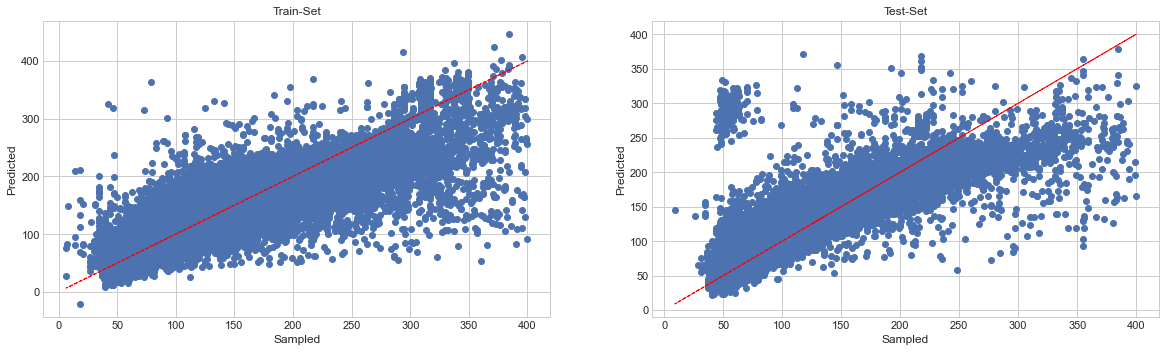

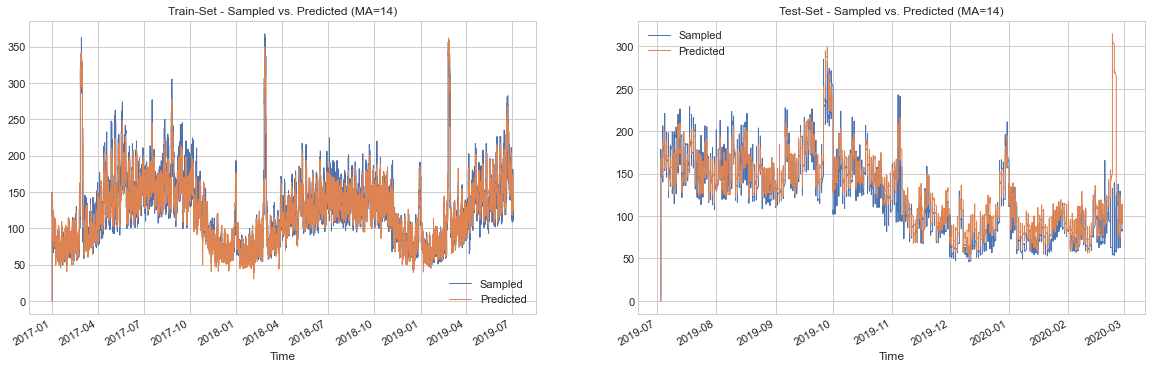

In [43]:
model_name = models[2]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)

else:

    # Create object
    model = Lasso(alpha=0.1)

    # Hyper-Parameters optimization:
    if hyper_params_en:

        model = GridSearchCV(model,
                             {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
                             scoring='r2', 
                             verbose=1,
                             n_jobs=1).estimator

    # Train the model using the training sets
    model.fit(X_train, y_train)

    # Save the model
    joblib.dump(model, model_file)
    
    # Get cross validation scores
    get_cv_scores(model, X_train, y_train)

print_model_accuracy(model, X_train, y_train, X_test, y_test)
    
# Make predictions using the testing set
y_pred = model.predict(X_test)

# Plot
plot_model_results(model, X_train, X_test, y_train, y_test, y_pred)

<hr>

### Elastic-Net Regressor

Elastic-net is a linear regression model that combines the penalties of Lasso (L1) and Ridge (L2).<br>

<div><img src="https://miro.medium.com/max/1312/1*oECWmvwOKotaAA0czR30vg.png" width="500"/></div>

Model: elasticnet_regressor
Train Accuracy:  0.7065353363031794
Test Accuracy:  0.6160220465328525


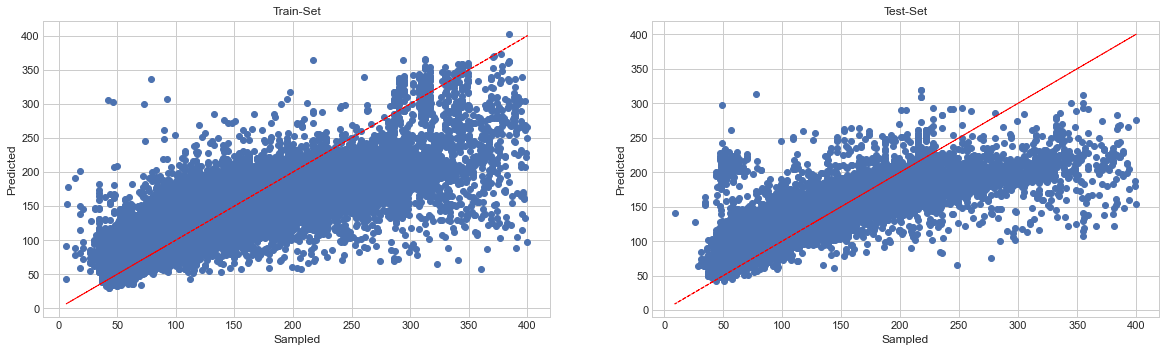

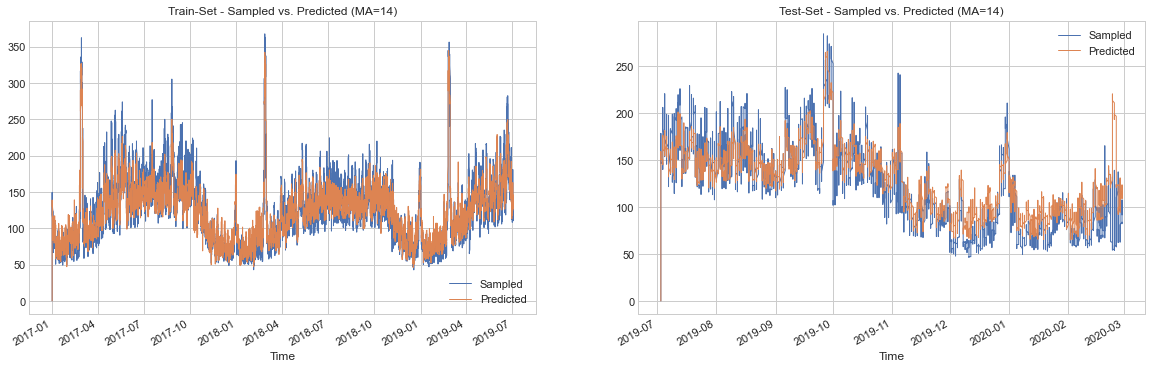

In [44]:
model_name = models[3]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)

else:

    # Create object
    model = ElasticNet(alpha=1, l1_ratio=0.5)

    # Hyper-Parameters optimization:
    if hyper_params_en:

        model = GridSearchCV(model,
                             {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                              'l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}, 
                             scoring='r2', 
                             verbose=1,
                             n_jobs=1).estimator

    # Train the model using the training sets
    model.fit(X_train, y_train)
    
    # Save the model
    joblib.dump(model, model_file)

    # Get cross validation scores
    get_cv_scores(model, X_train, y_train)

print_model_accuracy(model, X_train, y_train, X_test, y_test)

# Make predictions using the testing set
y_pred = model.predict(X_test)

# Plot
plot_model_results(model, X_train, X_test, y_train, y_test, y_pred)

### Support Vector Regressor

The method of Support Vector Classification can be extended to solve regression problems, termed as Support Vector Regression.<br>
The model produced by support vector classification (classic SVM) depends only on a subset of the training data, because the cost function for building the model does not care about training points that lie beyond the margin.<br>
Analogously, the model produced by Support Vector Regression depends only on a subset of the training data, because the cost function for building the model ignores any training data close to the model prediction.<br>
In simple regression we try to minimise the error rate. While in SVR we try to fit the error within a certain threshold<br>

<div><img src="https://miro.medium.com/max/1400/1*rs0EfF8RPVpgA-EfgAq85g.jpeg" width="500"/></div>

Model: supportvect_regressor
Train Accuracy:  0.7487384308321523
Test Accuracy:  0.09622213877207575


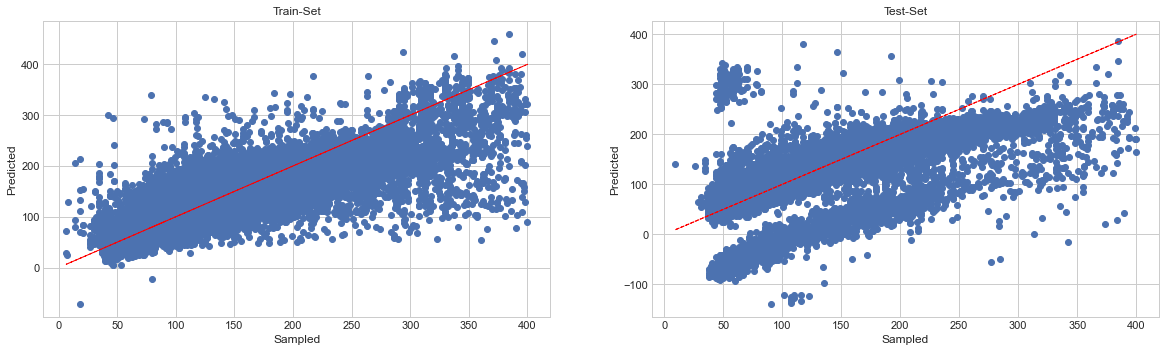

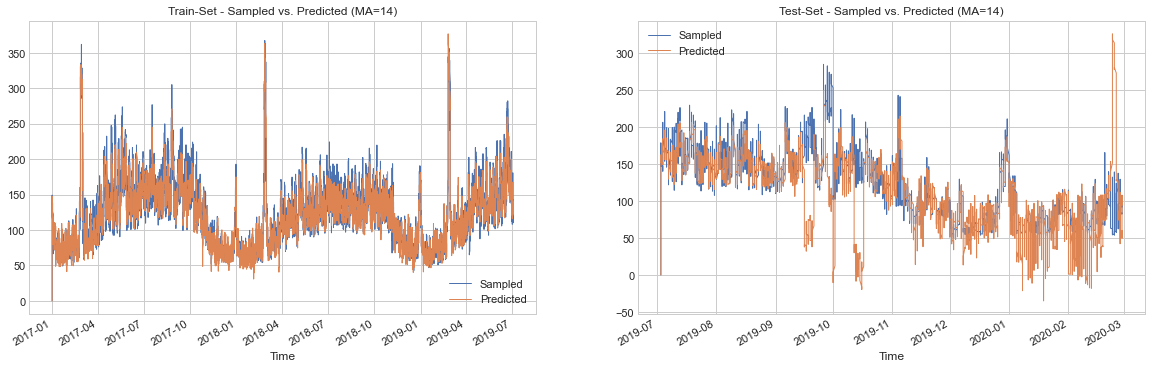

In [45]:
model_name = models[4]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)

else:

    # Create object
    model = LinearSVR(random_state=0, tol=1e-5)

    # Train the model using the training sets
    model = model.fit(X_train, y_train)

    # Save the model
    joblib.dump(model, model_file) 
    
    # Get cross validation scores
    get_cv_scores(model, X_train, y_train)

print_model_accuracy(model, X_train, y_train, X_test, y_test)

# Make predictions using the testing set
y_pred = model.predict(X_test)

# Plot
plot_model_results(model, X_train, X_test, y_train, y_test, y_pred)

<hr>

# Trees

### Decision Tree Regressor

<div><img src="https://miro.medium.com/max/1630/1*XZ220vTa7rN8ccJZZNe09w.png" width="500"/></div>

Model: decisiontree_regressor
Train Accuracy:  1.0
Test Accuracy:  0.3801446024464369


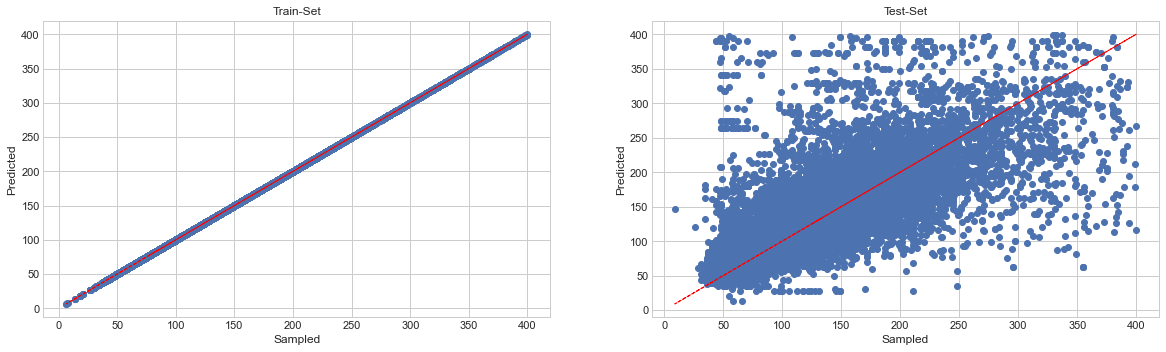

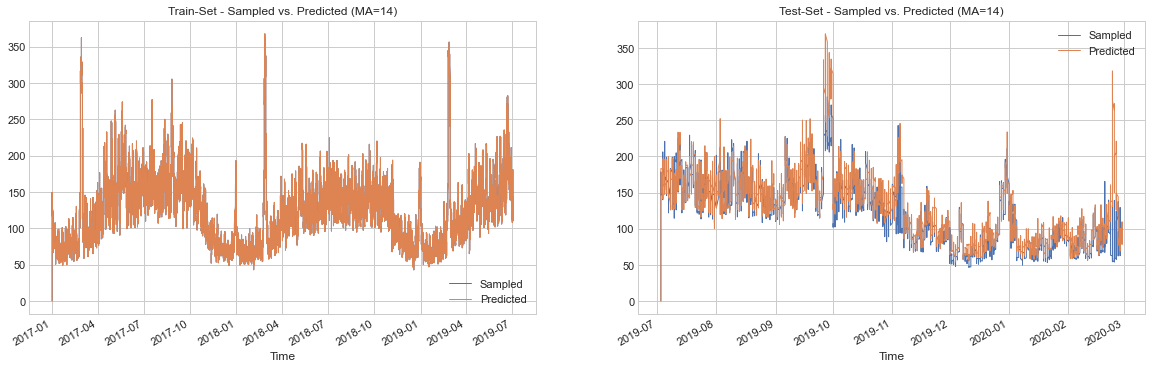

In [46]:
model_name = models[5]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)

else:

    # Create object
    model = DecisionTreeRegressor(random_state=0)

    # Train the model using the training sets
    model.fit(X_train, y_train)

    # Save the model
    joblib.dump(model, model_file)
    
    # Get cross validation scores
    get_cv_scores(model, X_train, y_train)

print_model_accuracy(model, X_train, y_train, X_test, y_test)
    
# Make predictions using the testing set
y_pred = model.predict(X_test)

# Plot
plot_model_results(model, X_train, X_test, y_train, y_test, y_pred)

Feature Importances

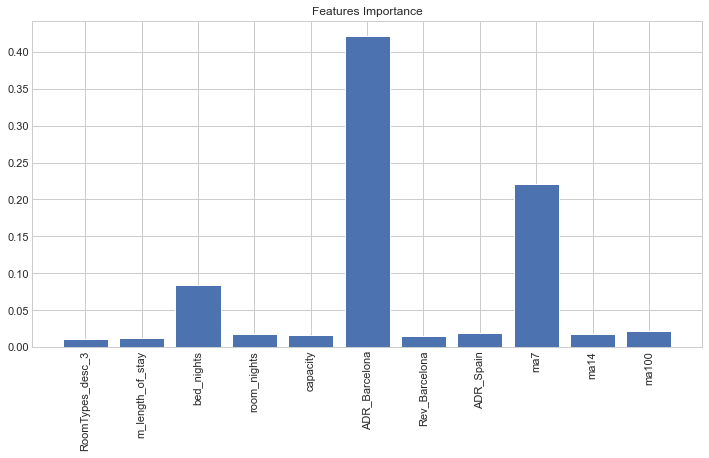

In [47]:
plot_tree_features_importance(model.feature_importances_, X_train.columns, 0.01)

Tree Visualization

In [48]:
%%script false --no-raise-error

plot_tree(model)

<hr>

### Random Forest Regressor

A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting<br>

<div><img src="https://databricks.com/wp-content/uploads/2015/01/Ensemble-example.png" width="500"/></div>

Model: randomforest_regressor
Train Accuracy:  0.4999398948180608
Test Accuracy:  0.45584392510435734


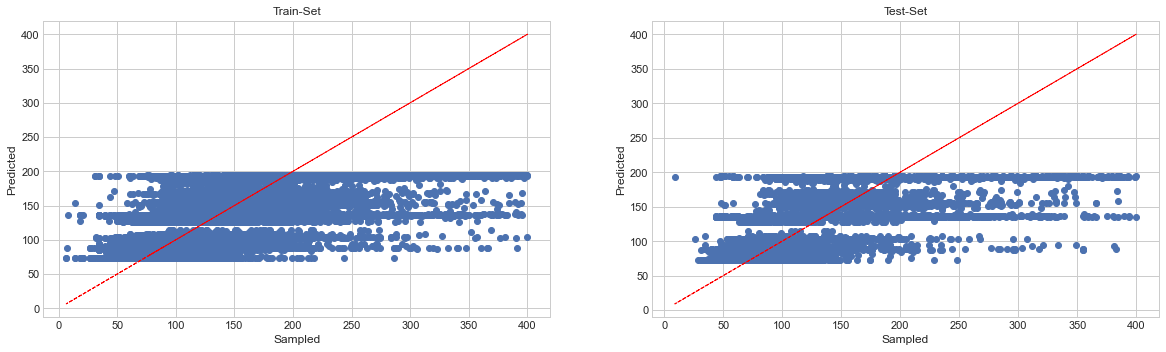

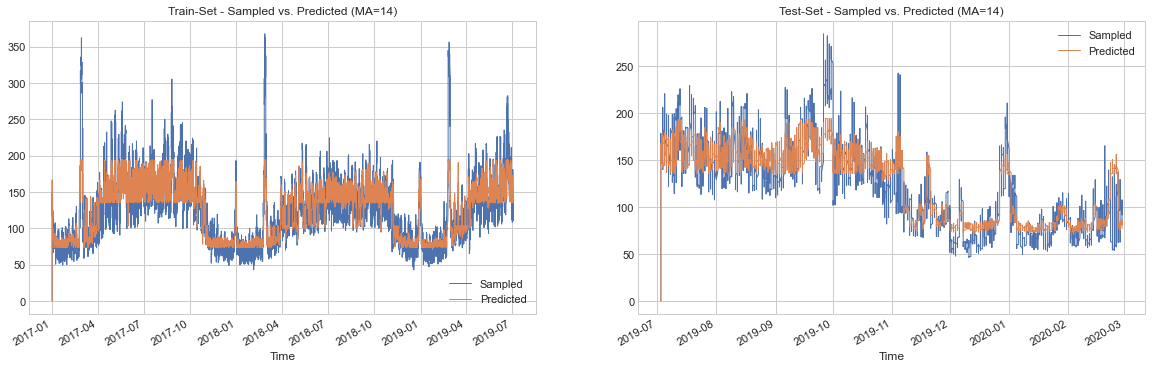

In [49]:
model_name = models[6]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)

else:

    # Create object
    model = RandomForestRegressor(max_depth=2, random_state=0)

    # Train the model using the training sets
    model.fit(X_train, y_train)

    # Save the model
    joblib.dump(model, model_file)
    
    # Get cross validation scores
    get_cv_scores(model, X_train, y_train)

print_model_accuracy(model, X_train, y_train, X_test, y_test)
    
# Make predictions using the testing set
y_pred = model.predict(X_test)

# Plot
plot_model_results(model, X_train, X_test, y_train, y_test, y_pred)

Feature Importances

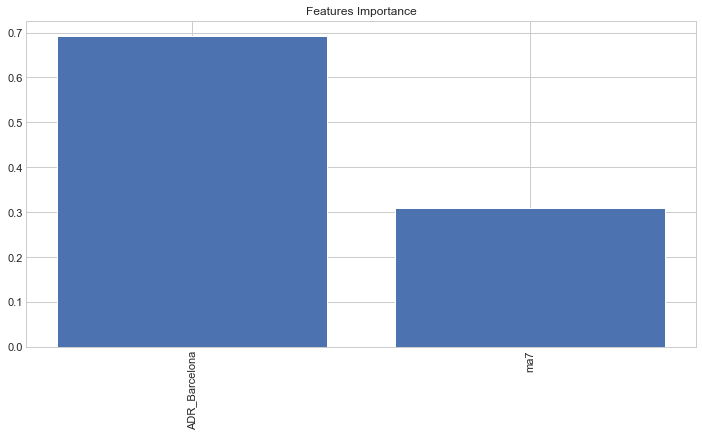

In [50]:
plot_tree_features_importance(model.feature_importances_, X_train.columns, 0.01)

<hr>

### XGBoost Regressor

XGBoost stands for “Extreme Gradient Boosting”, where the term “Gradient Boosting” originates from the paper Greedy Function Approximation: A Gradient Boosting Machine, by Friedman.<br>

<div><img src="https://miro.medium.com/max/1000/0*tzKt_ABz5rRrsGoW.jpg" width="500"/></div>

Model: xgboost_regressor
Train Accuracy:  0.8143311735045621
Test Accuracy:  0.6718573752502506


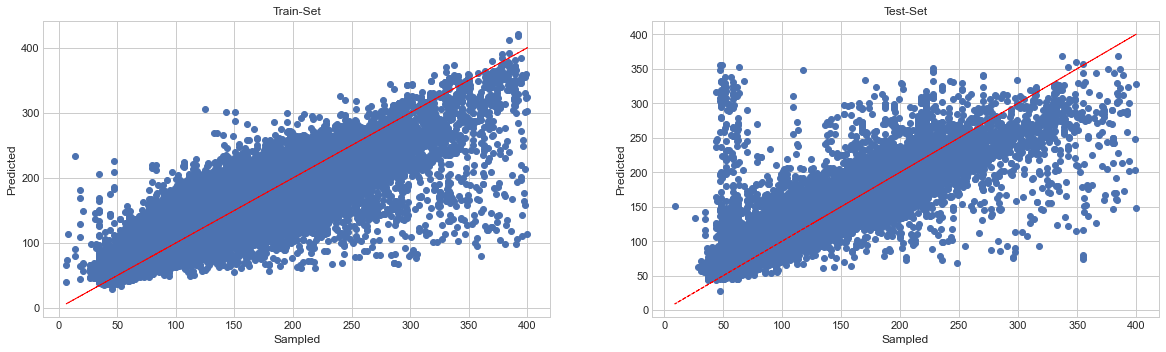

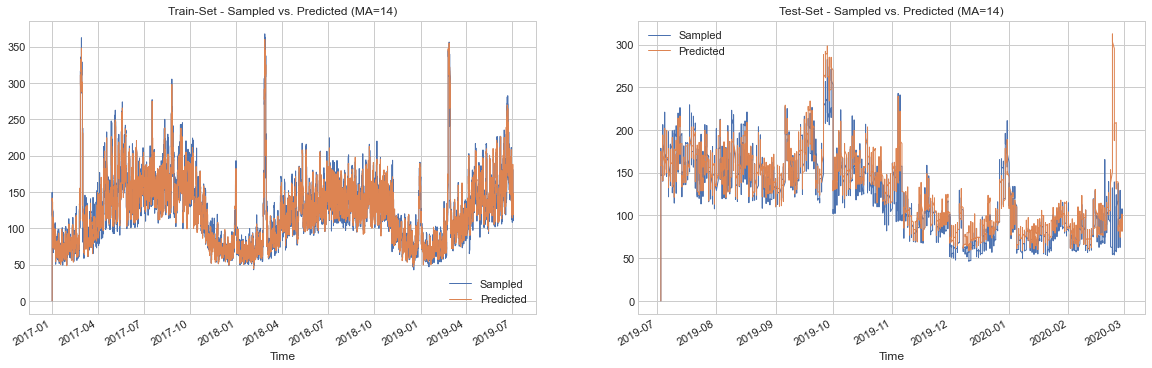

Base Score:  None


In [51]:
model_name = models[7]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)

else:
    
    # Create object
    model = xgb.XGBRegressor(objective='reg:squarederror', max_depth=4, n_estimators=100)

    # Hyper-Parameters optimization:
    if hyper_params_en:

        model = GridSearchCV(model,
                             {'max_depth': [2,4,6],
                              'n_estimators': [50,100,200]}, 
                             verbose=1,
                             n_jobs=1).estimator

    # Train the model using the training sets
    model.fit(X_train, y_train)
    
    # Save the model
    joblib.dump(model, model_file)

    # Get cross validation scores
    get_cv_scores(model, X_train, y_train)
    
print_model_accuracy(model, X_train, y_train, X_test, y_test)
    
# Make predictions using the testing set
y_pred = model.predict(X_test)

# Plot
plot_model_results(model, X_train, X_test, y_train, y_test, y_pred)

print('Base Score: ', model.base_score)

Feature Importances

Text(0.5, 1.0, 'Features Importance')

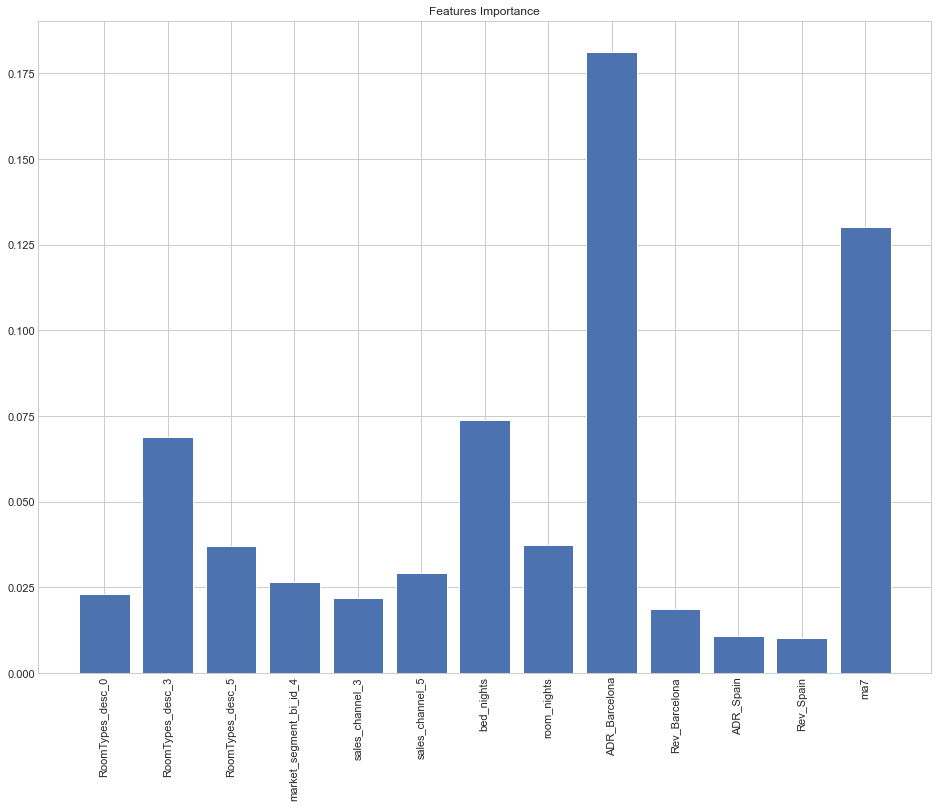

In [52]:
feature_import_thr = 0.01
feature_import_val = model.feature_importances_[model.feature_importances_ > feature_import_thr]
feature_import_lbl = X_train.columns[model.feature_importances_ > feature_import_thr]

plt.figure(figsize=(16,12))
plt.bar(feature_import_lbl, feature_import_val)
plt.xticks(rotation='vertical')
plt.title('Features Importance')

__Partial Dependency Plot (PDP)__ - create a dependence plot to show the effect of a single feature across the whole dataset ([reference](https://shap.readthedocs.io/en/latest/))

A dependence plot is a scatter plot that shows the effect a single feature has on the predictions made by the model.

- Each dot is a single prediction (row) from the dataset.
- The x-axis is the value of the feature on-focus
- The y-axis is the SHAP value for that feature, represents how much knowing that feature's value changes model's output for that sample's prediction
- The color corresponds to a second feature that may have an interaction effect with the feature we are plotting (chosen automatically by default). If an interaction effect is present between this other feature and the feature we are plotting it will show up as a distinct vertical pattern of coloring.

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


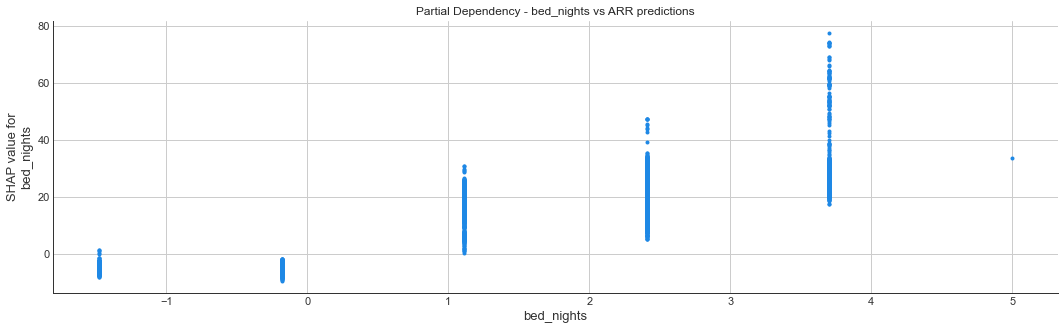

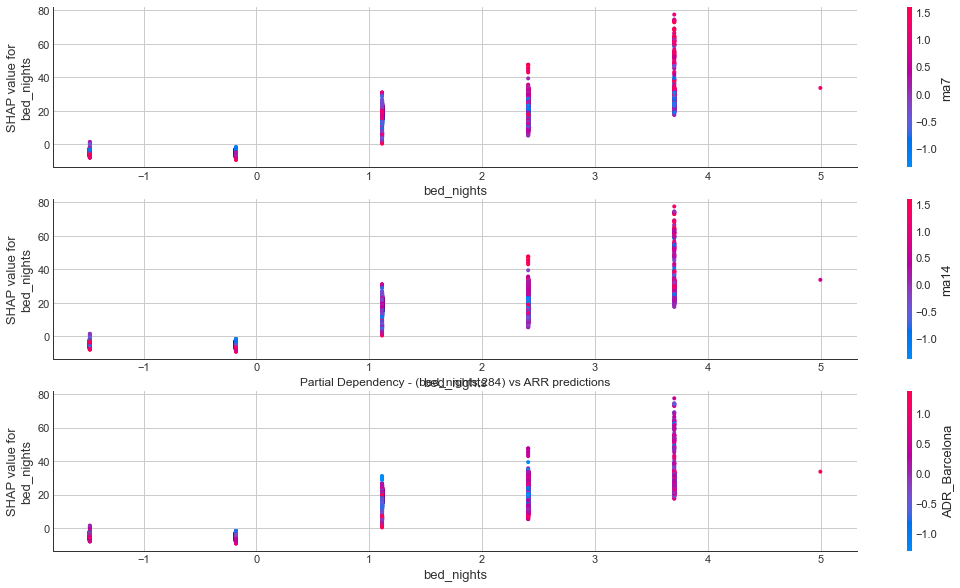

In [53]:
feature_id = 'bed_nights'

# Create object that can calculate shap values (SHapley Additive exPlanations)
explainer = shap.TreeExplainer(model)

# Calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(X_train)

# Turn off interaction coloring:
fig, ax = plt.subplots(1, 1, figsize=(18,5))
shap.dependence_plot(feature_id, shap_values, X_train, interaction_index=None, ax=ax, show=False)
plt.title('Partial Dependency - %s vs %s predictions' % (feature_id, dependent_var))
plt.show()

# Make plots colored by each of the top three possible interacting features
inds = shap.approximate_interactions(feature_id, shap_values, X_train)
fig, ax = plt.subplots(3, 1, figsize=(18,10))
for i in range(3):
    shap.dependence_plot(feature_id, shap_values, X_train, interaction_index=inds[i], ax=ax[i], show=False)
plt.title('Partial Dependency - (%s,%s) vs %s predictions' % (feature_id, inds[i], dependent_var))
plt.show()    

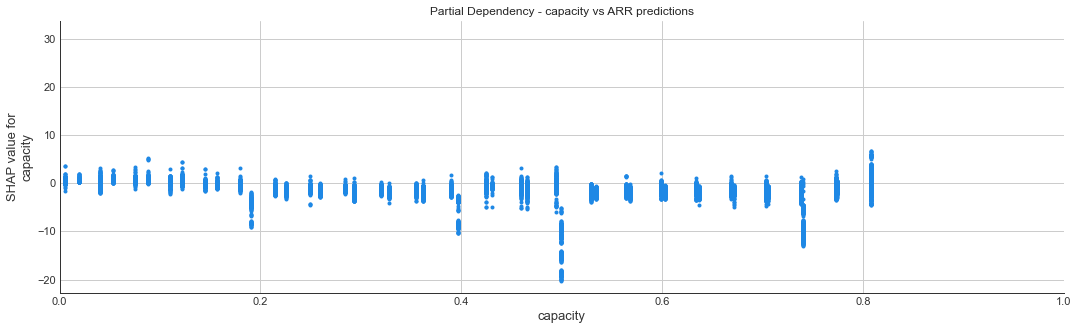

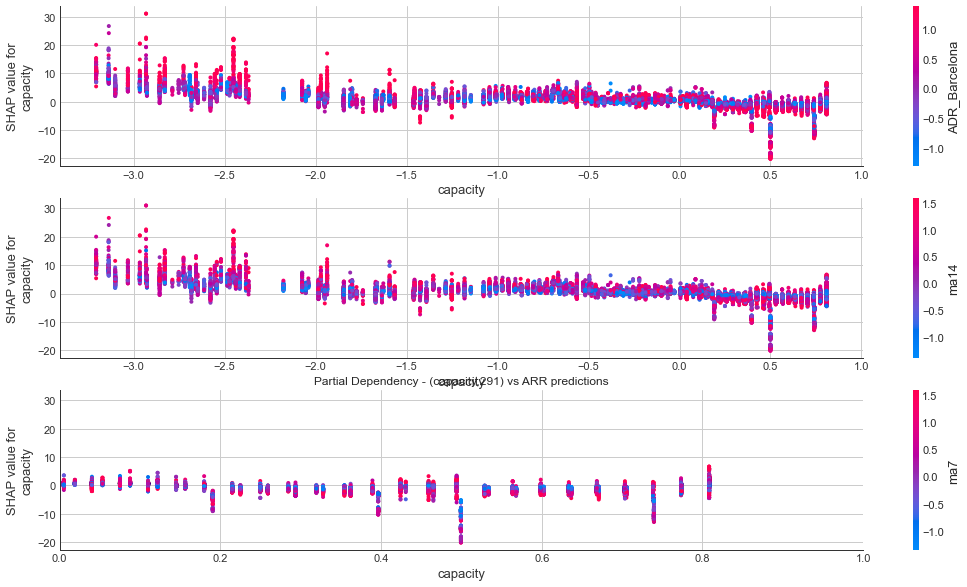

In [54]:
feature_id = 'capacity' if avail_path else 'bed_nights'

# Create object that can calculate shap values (SHapley Additive exPlanations)
explainer = shap.TreeExplainer(model)

# Calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(X_train)

# Turn off interaction coloring:
fig, ax = plt.subplots(1, 1, figsize=(18,5))
shap.dependence_plot(feature_id, shap_values, X_train, interaction_index=None, ax=ax, show=False)
plt.xlim([0,1])
plt.title('Partial Dependency - %s vs %s predictions' % (feature_id, dependent_var))
plt.show()

# Make plots colored by each of the top three possible interacting features
inds = shap.approximate_interactions(feature_id, shap_values, X_train)
fig, ax = plt.subplots(3, 1, figsize=(18,10))
for i in range(3):
    shap.dependence_plot(feature_id, shap_values, X_train, interaction_index=inds[i], ax=ax[i], show=False)
plt.xlim([0,1])
plt.title('Partial Dependency - (%s,%s) vs %s predictions' % (feature_id, inds[i], dependent_var))
plt.show()    

<hr>

# Neural Networks

### Multi-layer Perceptron

A Multi-layer Perceptron (MLP) Regression System is a multilayer feedforward neural network training system that implements multi-layer perceptron regression algorithm to solve a Multi-layer Perceptron Regression Task.<br>

<div><img src="https://miro.medium.com/max/1400/1*-IPQlOd46dlsutIbUq1Zcw.png" width="500"/></div>

Model: mlp_regressor
Train Accuracy:  0.9155757470711724
Test Accuracy:  0


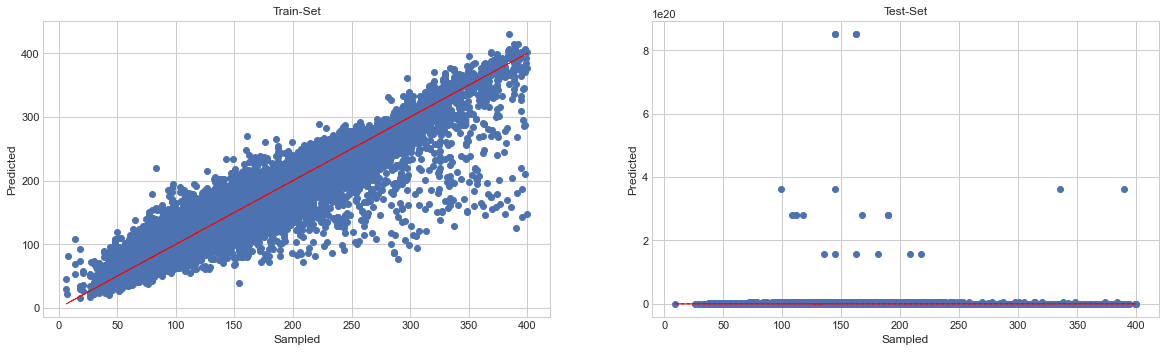

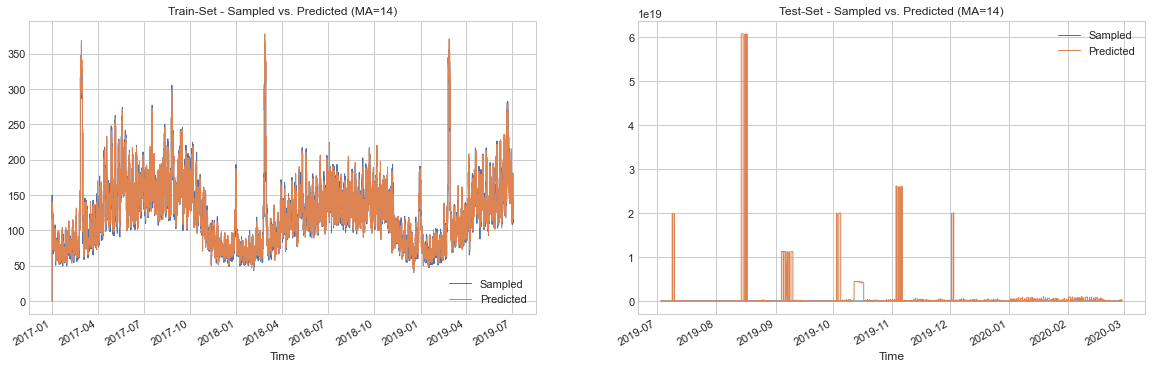

In [55]:
model_name = models[8]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)

else:
    
    # Create object
    model = make_pipeline(StandardScaler(),
                          MLPRegressor(hidden_layer_sizes=(100, 100),
                                       tol=1e-2, 
                                       max_iter=500,
                                       random_state=0))

    # Train the model using the training sets
    model.fit(X_train, y_train)
    
    # Save the model
    joblib.dump(model, model_file)

    # Get cross validation scores
    get_cv_scores(model, X_train, y_train)

print_model_accuracy(model, X_train, y_train, X_test, y_test)
    
# Make predictions using the testing set
y_pred = model.predict(X_test)

# Plot
plot_model_results(model, X_train, X_test, y_train, y_test, y_pred)

<hr>

### LSTM RNN (Tensorflow)

Recurrent Neural Networks (RNN) have been proven to efficiently solve sequence problems. Particularly, Long Short Term Memory Network (LSTM), which is a variation of RNN, is currently being used in a variety of domains to solve sequence problems.<br>
<br>
<div><img src="https://i.stack.imgur.com/Mpzfy.jpg" width="500"/></div>

In [56]:
def lstm_calculate_loss(model, dataset, dataset_idx, X_true, plot_en=True):

    # Predict:
    Xpred = model.predict(dataset)
    Xpred = pd.DataFrame(Xpred, index=dataset_idx, columns=[dependent_var])

    # Ground Truth:
    Xtrue = X_true.copy()
    Xtrue = pd.DataFrame(Xtrue, index=dataset_idx, columns=[dependent_var])

    # Loss calculation:
    loss_mae = pd.DataFrame(index=dataset_idx)
    loss_mae = np.mean(np.abs(Xpred-Xtrue), axis=1)

    # R2 score
    r2 = r2_score(Xtrue[dependent_var], Xpred[dependent_var])
    
    # Plot:
    if plot_en:
        fig, axes = plt.subplots(2, 1, figsize=(30,15))
        sns.distplot(loss_mae, bins=20, kde=True, color='blue', ax=axes[0])
        axes[0].set_title('Loss Distribution', fontsize=20)
        axes[0].set_xlabel('Loss Distribution', fontsize=15)
        #axes[0].set_xlim([0.0,.5])
        axes[1].set_title('Sampled vs. Predicted', fontsize=20)
        axes[1].set_xlabel('Time', fontsize=15)
        Xtrue[dependent_var].plot(subplots=True, ax=axes[1], color='Blue', label='Sampeld')
        Xpred[dependent_var].plot(subplots=True, ax=axes[1], color='Green', label='Predicted')
        axes[1].legend()
        plt.show()
        
    return loss_mae, Xtrue, Xpred, r2

Model: lstm_rnn
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               216576    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 216,705
Trainable params: 216,705
Non-trainable params: 0
_________________________________________________________________
None


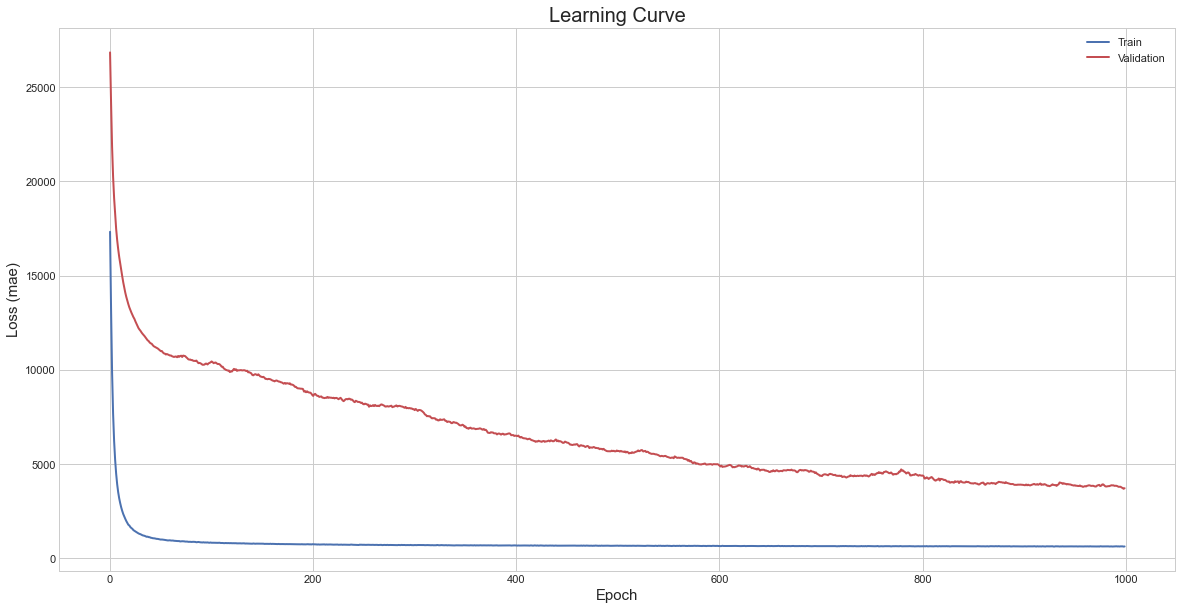

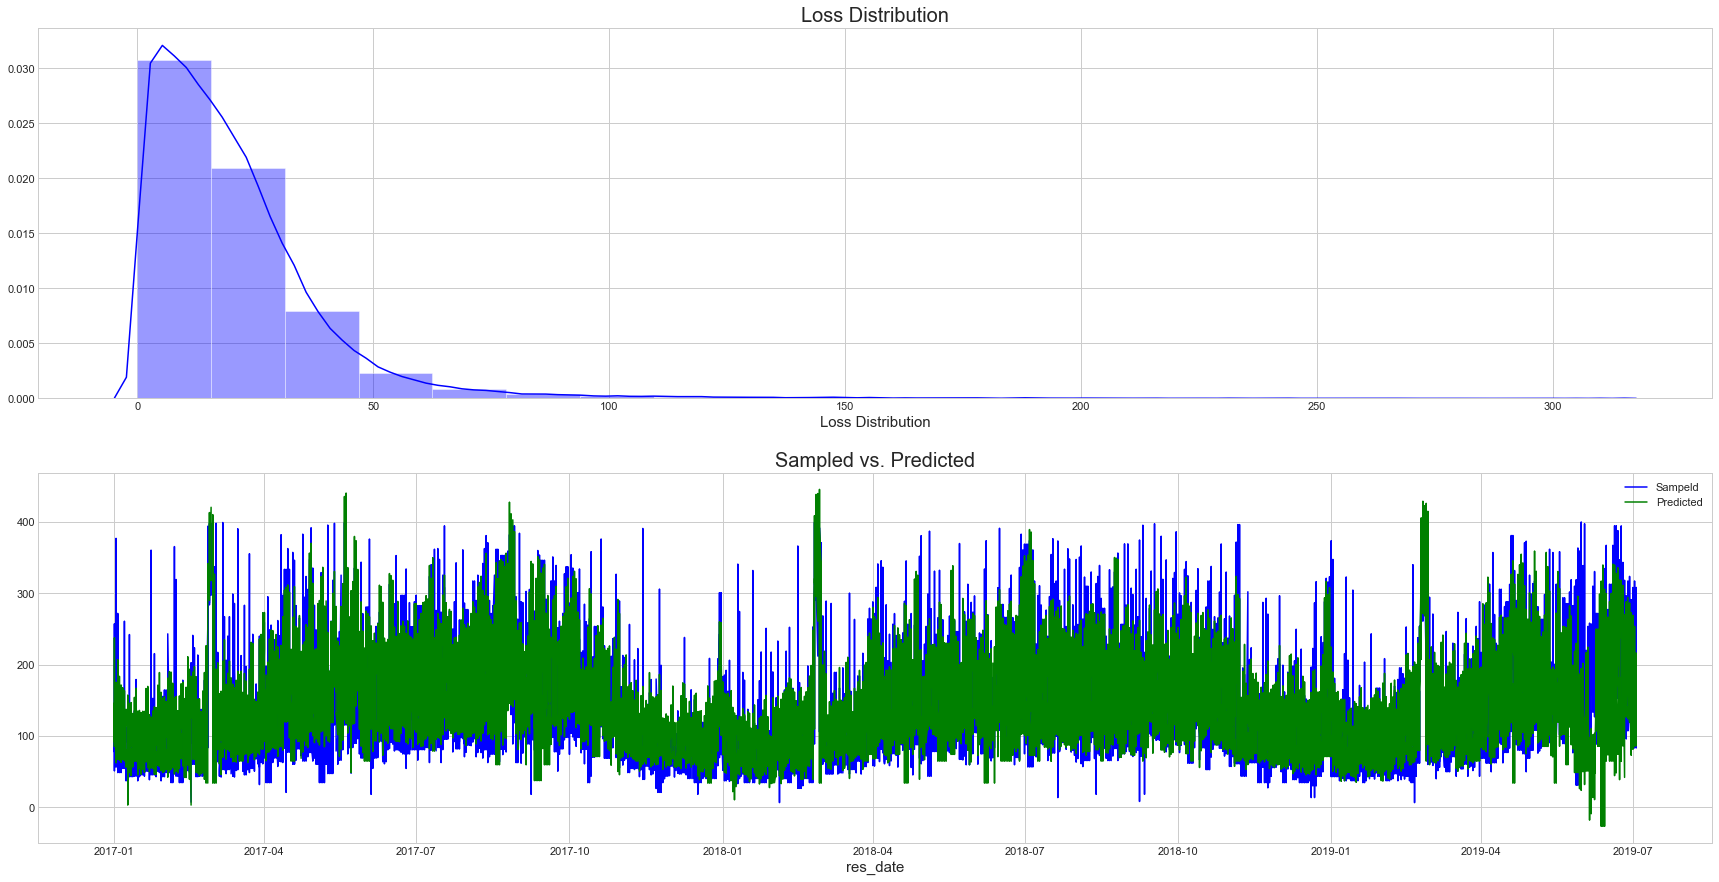

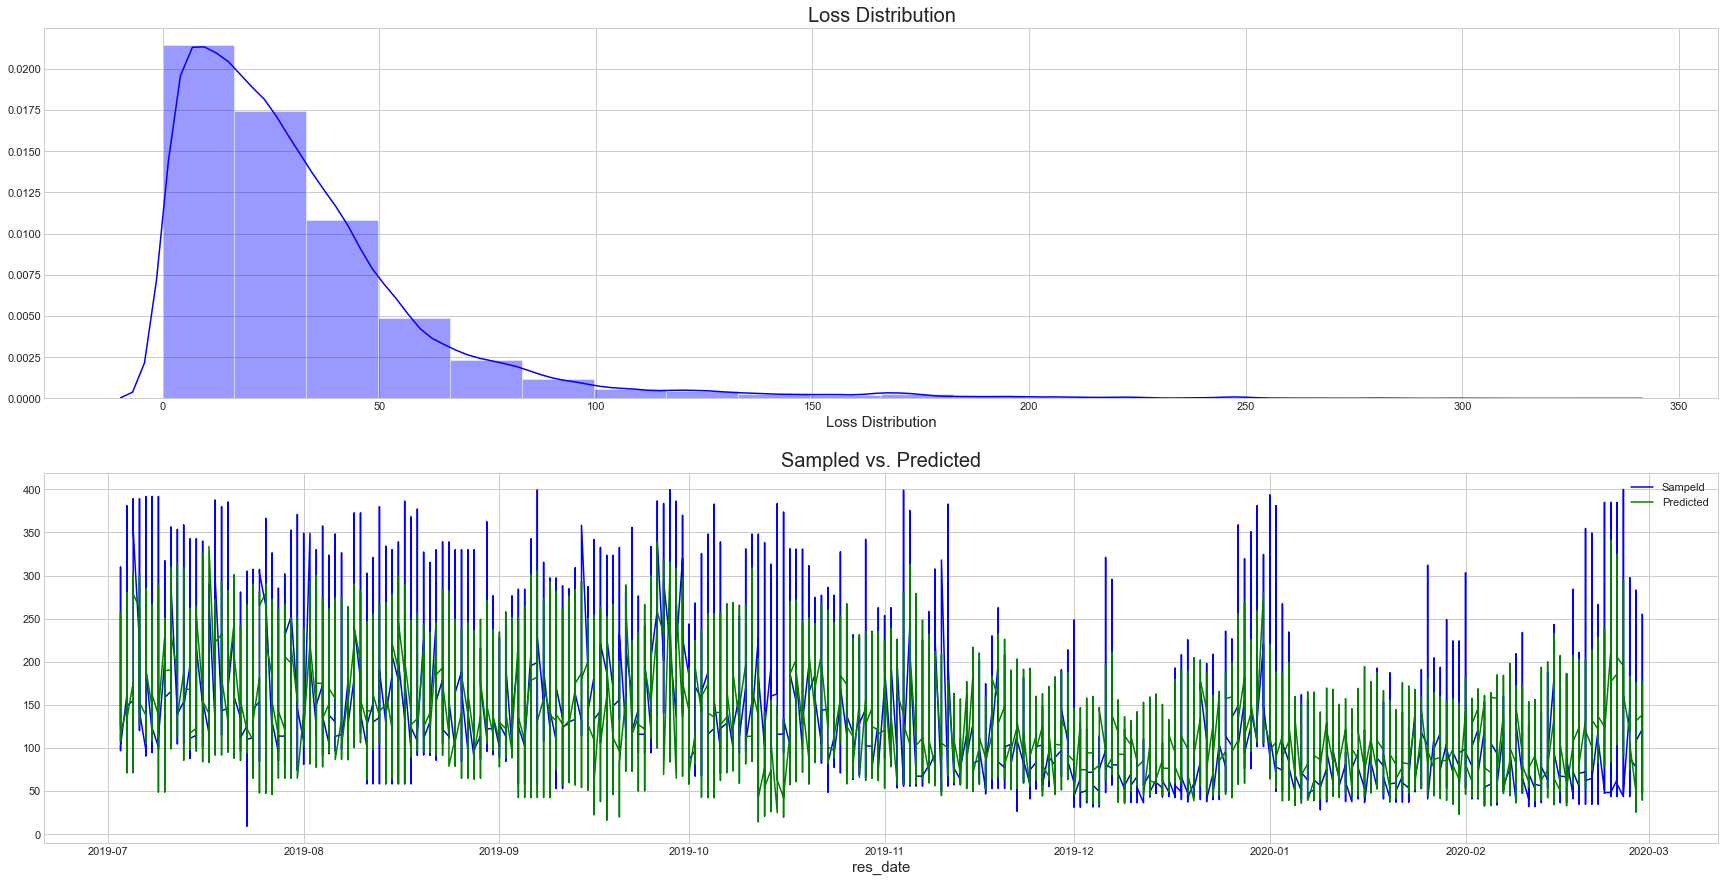

Train Accuracy: 0.73924 (loss MAE = 19.763)
Test Accuracy: 0.45568 (loss MAE = 9.244)


In [57]:
model_name = models[9]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.h5" % (model_name, hotel_sel)

# Dataframe to Numpy array
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()    

# Samples, TimeSteps, Features
X_train_shaped = X_train_np.reshape(X_train_np.shape[0], 1, X_train_np.shape[1])
X_test_shaped = X_test_np.reshape(X_test_np.shape[0], 1, X_test_np.shape[1])

# Samples, Features
y_train_shaped = y_train_np.reshape(y_train_np.shape[0], 1)
y_test_shaped = y_test_np.reshape(y_test_np.shape[0], 1)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = load_model(model_file)
    history = joblib.load(model_file.replace('.h5','.pkl'))
    
else:
    
    # TensorFlow Initialization
    tf.compat.v1.set_random_seed(33)
    environ['PYTHONHASHSEED'] = str(33)
    np.random.seed(33)
    stacked_lstm = False
    n_nuerons = 128
    
    # Create the LSTM RNN model
    model = Sequential()
    if stacked_lstm:
        model.add(LSTM(n_nuerons, return_sequences=True, input_shape=(1, X_train.shape[1]), dropout=0.3))
        model.add(LSTM(n_nuerons/2, return_sequences=True, dropout=0.3))
        model.add(LSTM(n_nuerons/4, return_sequences=True, dropout=0.3))
        model.add(LSTM(n_nuerons/8, dropout=0.3))
    else:
        model.add(LSTM(n_nuerons, input_shape=(1, X_train.shape[1]), dropout=0.3))                      
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    
    # Fit the model to the data
    history = model.fit(X_train_shaped,
                        y_train_shaped,
                        epochs=1000, 
                        batch_size=512,
                        validation_split=0.05,
                        verbose=2).history
    
    # Save all model information, including weights, in h5 format
    model.save(model_file)
    print("Model saved (%s)" % model_file)

    # Save history to pickle
    joblib.dump(history, model_file.replace('.h5','.pkl'))

# Print Model summary
print(model.summary())

# Plot learning-curve
plot_learning_curve(history)

# Evaluate model:
(loss_mae_trn, X_true_trn, X_pred_trn, r2_trn) = lstm_calculate_loss(
    model, X_train_shaped, X_train.index, y_train_shaped)

(loss_mae_tst, X_true_tst, X_pred_tst, r2_tst) = lstm_calculate_loss(
    model, X_test_shaped, X_test.index, y_test_shaped)

# Save R2 results
if 'r2_train' not in history:
    history = joblib.load(model_file.replace('.h5','.pkl'))
    history['r2_train'] = r2_trn
    history['r2_test'] = r2_tst
    joblib.dump(history, model_file.replace('.h5','.pkl'))

# Calculate Accuracy
print('Train Accuracy: %.5f (loss MAE = %.3f)' % (r2_trn, loss_mae_trn.iloc[-1]))
print('Test Accuracy: %.5f (loss MAE = %.3f)' % (r2_tst, loss_mae_tst.iloc[-1]))

<hr>

### LSTM AutoEncoder (Tensorflow)

LSTM Autoencoders are composed by a simple LSTM encoder layer, followed by another simple LSTM decoder and by  TimeDistributed layer at the end.<br>
The idea here is to treat the dependant variable (y) as part of the features (X). We'll try to encode the whole set (Xy) and the decode it back.<br>
We will create a composite LSTM Autoencoder that has a single encoder and two decoders, one for reconstruction and one for prediction.<br>
<br>
<div><img src="https://miro.medium.com/max/1400/1*ZAorCoNenSYwDhTkFzqEGw.jpeg" width="500"/></div>

In [58]:
def autoencoder_calculate_loss(model, dataset, dataset_cols, dataset_idx, scaler_xy, plot_en=True):

    # Predict:
    Xpred = model.predict(dataset)
    Xpred = Xpred.reshape(Xpred.shape[0], Xpred.shape[1])
    Xpred = pd.DataFrame(Xpred, columns=dataset_cols)
    Xpred.index = dataset_idx

    # Ground Truth:
    Xtrue = dataset.reshape(dataset.shape[0], dataset.shape[1])
    Xtrue = pd.DataFrame(Xtrue, columns=dataset_cols)
    Xtrue.index = dataset_idx

    # Loss calculation:
    loss_mae = pd.DataFrame(index=dataset_idx)
    loss_mae = np.mean(np.abs(Xpred-Xtrue), axis=1)

    # UnScaling:
    Xy_dummy = dataset.copy()
    Xy_dummy = Xy_dummy.reshape(Xy_dummy.shape[0], Xy_dummy.shape[1])
    Xy_dummy = pd.DataFrame(Xy_dummy, columns=dataset_cols)
    Xy_dummy.index = dataset_idx
    Xy_dummy[dependent_var] = Xpred[dependent_var].values
    y_pred = scaler_xy.inverse_transform(Xy_dummy)[:, [-1]]
    Xy_dummy[dependent_var] = Xtrue[dependent_var].values
    y_true = scaler_xy.inverse_transform(Xy_dummy)[:, [-1]]
    
    # R2 score
    r2 = r2_score(Xtrue[dependent_var], Xpred[dependent_var])    
    
    # Plot:
    if plot_en:
        
        y_smp = pd.DataFrame(y_true, index=dataset_idx)
        y_prd = pd.DataFrame(y_pred, index=dataset_idx)

        y_smp_ma = y_smp.groupby(y_smp.index).mean().rolling(window=14).mean().fillna(0)
        y_prd_ma = y_prd.groupby(y_prd.index).mean().rolling(window=14).mean().fillna(0)

        y_ma = pd.concat([y_smp_ma, y_prd_ma], axis=1)
        y_ma.columns = ['Sampled', 'Predicted']
        
        fig, ax = plt.subplots(1, 1, figsize=(15,10))
        sns.distplot(loss_mae, bins=20, kde=True, color='blue', ax=ax)
        ax.set_title('Loss Distribution', fontsize=20)
        ax.set_xlabel('Loss Distribution', fontsize=15)
        #ax.set_xlim([0.0,.5])
        plt.show()

        fig, ax = plt.subplots(1, 1, figsize=(15,10))
        y_ma.plot(ax=ax, linewidth=1)
        ax.xaxis_date()
        ax.set_title('Sampled vs. Predicted (MA=14)')
        ax.set_xlabel('Time')
        ax.legend()
        fig.autofmt_xdate()        
        plt.show()
        
    return loss_mae, Xtrue, Xpred, r2

In [59]:
%%script false --no-raise-error

model_name = models[10]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.h5" % (model_name, hotel_sel)

# Dataframe to Numpy array
X_train_np = Xy_train.to_numpy()
X_test_np = Xy_test.to_numpy()

# Reshape inputs for LSTM [samples, features, timesteps]
X_train_shaped = X_train_np.astype(np.float64).reshape(X_train_np.shape[0], X_train_np.shape[1], 1)
X_test_shaped = X_test_np.astype(np.float64).reshape(X_test_np.shape[0], X_test_np.shape[1], 1)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = load_model(model_file)
    history = joblib.load(model_file.replace('.h5','.pkl'))
    
else:

    # TensorFlow Initialization
    tf.compat.v1.set_random_seed(33)
    environ['PYTHONHASHSEED'] = str(33)
    np.random.seed(33)

    sequence_length = 4

    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1, 
        inter_op_parallelism_threads=1
    )
    sess = tf.compat.v1.Session(
        graph=tf.compat.v1.get_default_graph(), 
        config=session_conf
    )
    tf.compat.v1.keras.backend.set_session(sess)

    # Create the autoencoder model
    sequence_length = X_train_np.shape[1]
    inputs_ae = Input(shape=(sequence_length, 1))
    encoded_ae = LSTM(128, return_sequences=True, dropout=0.3)(inputs_ae, training=True)
    decoded_ae = LSTM(32, return_sequences=True, dropout=0.3)(encoded_ae, training=True)
    out_ae = TimeDistributed(Dense(1))(decoded_ae)

    model = Model(inputs_ae, out_ae)
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])

    # Fit the model to the data
    history = model.fit(X_train_shaped,
                        X_train_shaped,
                        epochs=100,
                        batch_size=128,
                        validation_split=0.2,
                        verbose=2,
                        shuffle=True).history

    # Save all model information, including weights, in h5 format
    model.save(model_file)
    print("Model saved (%s)" % model_file)

    # Save history to pickle
    joblib.dump(history, model_file.replace('.h5','.pkl'))

# Print Model summary
print(model.summary())
    
# Plot learning-curve
plot_learning_curve(history)

# Evaluate model:
(loss_mae_trn, X_true_trn, X_pred_trn, r2_trn) = autoencoder_calculate_loss(
    model, X_train_shaped, Xy_train.columns, Xy_train.index, scaler_xy_train)

(loss_mae_tst, X_true_tst, X_pred_tst, r2_tst) = autoencoder_calculate_loss(
    model, X_test_shaped, Xy_test.columns, Xy_test.index, scaler_xy_test)

# Save R2 results
if 'r2_train' not in history:
    history = joblib.load(model_file.replace('.h5','.pkl'))
    history['r2_train'] = r2_trn
    history['r2_test'] = r2_tst
    joblib.dump(history, model_file.replace('.h5','.pkl'))

# Calculate Accuracy
print('Train Accuracy: (r2, loss MAE): %.5f, %.3f' % (r2_trn, loss_mae_trn.iloc[-1]))
print('Test Accuracy: (r2, loss MAE): %.5f, %.3f' % (r2_tst, loss_mae_tst.iloc[-1]))

### Forecasting

WIP

<hr>

# Statistical Forecasting

### SARIMAX

An ARIMA model is one where a time series get differenced d times to make it stationary, and then combine the AR and the MA terms.   
So the equation becomes:
<br>
<br>
$
\begin{align}
Y_t = \alpha + \beta_1Y_{t-1} + \beta_2Y_{t-2} + ... + \beta_pY_{t-p} + \epsilon_t + \phi_1\epsilon_{t-1} + \phi_2\epsilon_{t-2} + ... + \phi_q\epsilon_{t-q}
\end{align}
$
<br>
<br>
Linear regression models work best when the predictors are not correlated and are independent of each other.   
Hence, the first step to build an ARIMA model is to __make the time series stationary__.   
<br>
The __SARIMAX__ extension of ARIMA that explicitly models the seasonal element in univariate data.
<br>
<br>
There are three __trend elements__ (same as in the ARIMA model):
- p: Trend autoregression order
- d: Trend difference order
- q: Trend moving average order

There are four __seasonal elements__ (not part of ARIMA):
- P: Seasonal autoregressive order.
- D: Seasonal difference order.
- Q: Seasonal moving average order.
- m: The number of time steps for a single seasonal period.

In [60]:
def test_adf(series):
    '''
    Augmented Dickey-Fuller is the most popular statistical method to find if the series is stationary or not.
    It is also called as Unit Root Test.
    If value of p <0.05, then the data is stationary else the data is not stationary.
    '''
    
    dfout = {}
    dftest = sm.tsa.adfuller(series.dropna(), 
                             autolag='AIC', 
                             regression='ct')
    
    for key,val in dftest[4].items():
        dfout[f'critical value ({key})'] = val
    
    adf_p_value = dftest[1]
    
    is_stationary = adf_p_value <= 0.05
    
    if is_stationary:
        print("Strong evidence against Null Hypothesis")
        print("Reject Null Hypothesis - Data is Stationary")
        print("Data is Stationary (p=%.5f)" % adf_p_value)
    else:
        print("Strong evidence for  Null Hypothesis")
        print("Accept Null Hypothesis - Data is not Stationary")
        print("Data is NOT Stationary (p=%.2f) for " % adf_p_value)
    
    return is_stationary

Strong evidence against Null Hypothesis
Reject Null Hypothesis - Data is Stationary
Data is Stationary (p=0.00000)
Model: sarima
(p,d,q) = (2, 0, 1)
(P,D,Q,s) = (0, 0, 0, 0)
AIC = -148841.21


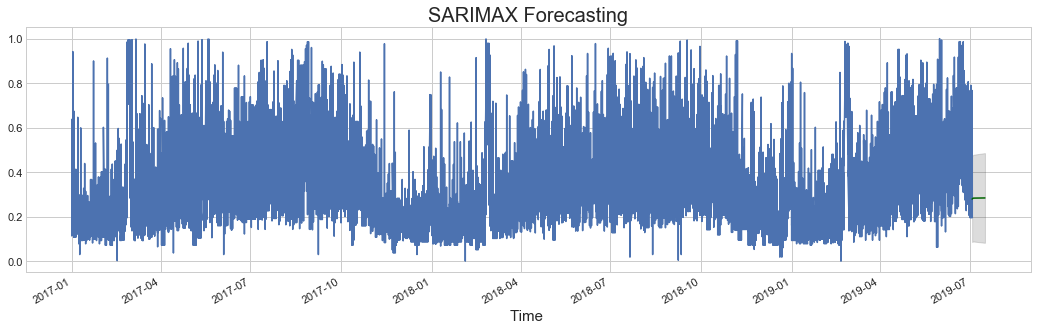

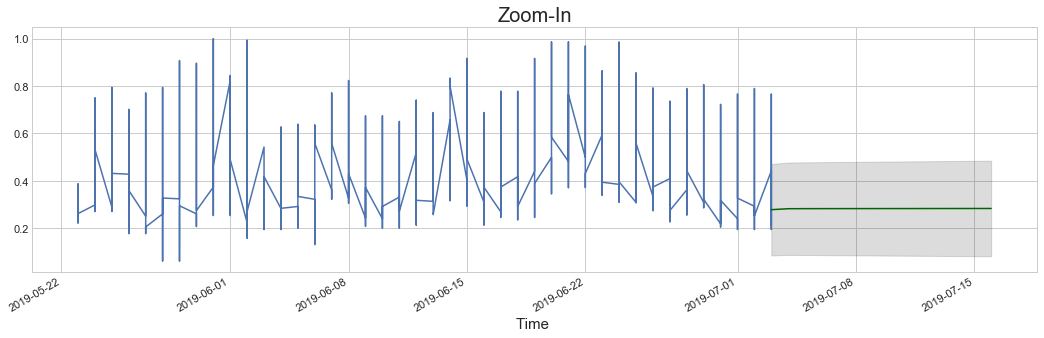

In [61]:
n_periods = 14  # amount of future time-samples to predict
n_zoom_in = 4000  # plotting zoom-in (last 'n_zoom_in' time-samples) 

# Normalization
sc_in = MinMaxScaler(feature_range=(0, 1))
out = pd.DataFrame(sc_in.fit_transform(pd.DataFrame(y_train)))
out.rename(columns={0:dependent_var}, inplace=True)

# Stationarity check
is_stationary = test_adf(out[dependent_var])
if not is_stationary:
    test_adf(out.diff())
    
model_name = models[11]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)
    
else:

    # Create the arima model + Auto Fit:
    model = auto_arima(out,
                       start_p=1,        # min_p (AR term)
                       start_q=1,        # min_q (MA term)
                       test='adf',       # use ADF test to find optimal 'd'
                       max_p=3,          # max p (AR term)
                       max_q=3,          # max q (MA term)
                       m=1,              # frequency of series
                       d=None,           # let model determine 'd'
                       seasonal=True,    # True for SARIMAX, False for No Seasonality
                       start_P=0,        # min_P (AR term of the seasonal model)
                       D=None,           # let model determine 'D'
                       trace=False,
                       error_action='ignore',  
                       suppress_warnings=True, 
                       stepwise=True)

    # Save the model
    joblib.dump(model, model_file)

print('(p,d,q) = %s' % str(model.get_params()['order']))
print('(P,D,Q,s) = %s' % str(model.get_params()['seasonal_order']))        
print('AIC = %.2f' % model.aic())

out.index = y_train.index

# Forecast
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)

# Make series for plotting purpose
fc_series = pd.Series(fc, index=pd.date_range(start=out.index[-1], periods=n_periods, freq='D'))

lower_series = pd.Series(confint[:, 0], index=fc_series.index)
upper_series = pd.Series(confint[:, 1], index=fc_series.index)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(18,5))
ax.set_title('SARIMAX Forecasting', fontsize=20)
ax.set_xlabel('Time ', fontsize=15)
ax.plot(out)
ax.plot(fc_series, color='darkgreen')
ax.xaxis_date()
ax.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
fig.autofmt_xdate()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(18,5))
ax.set_title('Zoom-In', fontsize=20)
ax.set_xlabel('Time ', fontsize=15)
ax.plot(out[-n_zoom_in:])
ax.plot(fc_series, color='darkgreen')
ax.xaxis_date()
ax.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
fig.autofmt_xdate()
plt.show()

### FBProphet

[Facebook Prophet](https://facebook.github.io/prophet/) is an additive regression model with four main components:
- A piecewise linear or logistic growth curve trend. Prophet automatically detects changes in trends by selecting changepoints from the data.
- A yearly seasonal component modeled using Fourier series.
- A weekly seasonal component using dummy variables.
- A user-provided list of important holidays.

Model: fbprophet


The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.


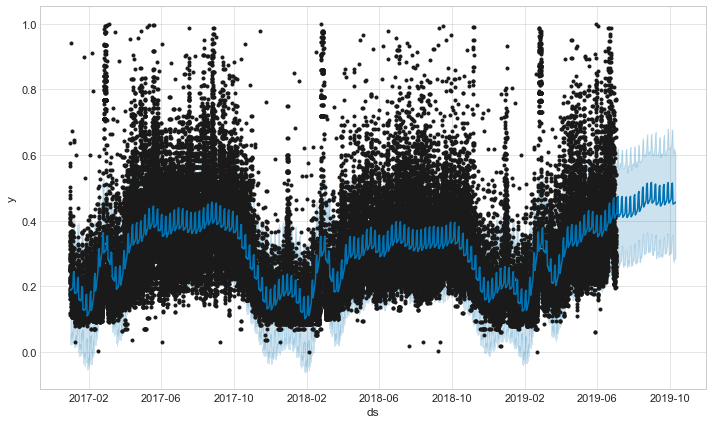

In [62]:
# Change the column names according to Prophet's guidelines:
out_df = out.copy().reset_index()
out_df.columns = ['ds', 'y']
out_df.T

# Split into a train/test set:
prediction_size = 100
train_df = out_df[:-prediction_size]

# Build an Prophet model:
model_name = "fbprophet"
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)

else:

    model = Prophet()
    model.fit(train_df)
    
    # Save the model
    joblib.dump(model, model_file)
        
# Forecast:
future_df = model.make_future_dataframe(periods=prediction_size)
forecast_df = model.predict(future_df)
forecast_df.head()

# Plot forecast
model.plot(forecast_df)
plt.show()

# Plot forecast components:
#model.plot_components(forecast_df)
#plt.show()

<hr>

# Summary

In [63]:
summary = { 'train_accuracy': {}, 
            'test_accuracy': {} } 

for model_name in models:
    
    if model_name == 'sarima' or model_name == 'fbprophet' or model_name == 'lstm_autoencoder':
        continue
    
    model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

    if path.isfile(model_file):
        
        model = joblib.load(model_file)
        
        if type(model) is dict:
            summary['train_accuracy'][model_name] = model['r2_train']
            summary['test_accuracy'][model_name] = model['r2_test']
        else:
            summary['train_accuracy'][model_name] = model.score(X_train, y_train)
            summary['test_accuracy'][model_name] = model.score(X_test, y_test)
    
    else:
        print("Skipping: %s" % model_file)
          
summary_df = pd.DataFrame(summary).astype(float).round(4)
summary_df[abs(summary_df)>1] = 0
display(summary_df)

,train_accuracy,test_accuracy
linear_regressor,0.7472,0.0000
ridge_regressor,0.7539,0.6107
lasso_regressor,0.7525,0.6148
elasticnet_regressor,0.7065,0.6160
supportvect_regressor,0.7487,0.0962
decisiontree_regressor,1.0000,0.3801
randomforest_regressor,0.4999,0.4558
xgboost_regressor,0.8143,0.6719
mlp_regressor,0.9156,0.0000
lstm_rnn,0.7392,0.4557


<hr>

In [64]:
print('Completed')

Completed
